# Work flow

1) Load images (random sample)

2) Crop flags

3) Split synthetic data (Train, Val, Test)

4) Feature extraction on cropped images

5) Label data

6) Train the model

7) Classification of flags

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! pip install opencv-python
# ! pip install scikit-image

In [ ]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import time

# Feature extraction
from skimage.feature import hog, local_binary_pattern
from skimage import exposure

# PCA & tSNE Libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf

In [ ]:
print("TF version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TF version: 2.18.0
GPU devices: []


## Load Datasets (Synthetic and Real)

In [ ]:
# Colab dirs

synthetic_dataset_path = "/content/drive/My Drive/281_flags_dataset/train_images/040525a_combined/"  #Adi
#synthetic_dataset_path = "/content/drive/My Drive/281_flags_project/281_flags_dataset/train_images/040525a_combined/" # Path, National Flags Combined  Dataset (Flipped included)
#synthetic_dataset_path = "/content/drive/My Drive/DATASCI_281/281_flags_project/281_flags_dataset/train_images/040525a_combined/"  # Matthew's Path

#real_dataset_path = "/content/drive/My Drive/281_flags_project/281_flags_dataset/test_images/test_cropped/" # Cleaned data
real_dataset_path = "/content/drive/My Drive/281_flags_dataset/test_images/test_cropped/" # Adi's path, Cleaned data
#real_dataset_path = "/content/drive/My Drive/DATASCI_281/281_flags_project/281_flags_dataset/test_images/test_cropped/" # Matthew's Path

#synthetic_dataset_path = "/content/drive/MyDrive/datasci_281/281_flags_project/281_flags_dataset/train_images/040525a_combined/"  #Anshul's
#real_dataset_path = "/content/drive/MyDrive/datasci_281/281_flags_project/281_flags_dataset/test_images/test_cropped/" # Anshul's path, Cleaned data

In [ ]:
# Local dirs

# synthetic_dataset_path = "./281_flags_project/train_images/train_national/"
# real_dataset_path = "./281_flags_project/test_cropped/"

In [ ]:
# Accessing each folder
synthetic_categories = sorted([folder for folder in os.listdir(synthetic_dataset_path) if os.path.isdir(os.path.join(synthetic_dataset_path, folder))])
real_categories = sorted([folder for folder in os.listdir(real_dataset_path) if os.path.isdir(os.path.join(real_dataset_path, folder))])# ✅ Create label mappings for both training & test datasets
synthetic_labels_dict = {category: idx for idx, category in enumerate(synthetic_categories)}
real_labels_dict = {category: idx for idx, category in enumerate(real_categories)}

print(f"Synthetic Categories: {synthetic_categories}")
print(f"Synthetic Label Mapping: {synthetic_labels_dict}")
print("")
print(f"Real Categories: {real_categories}")
print(f"Real Label Mapping: {real_labels_dict}")

Synthetic Categories: ['boogaloo', 'canada', 'france', 'india', 'proudboys', 'threepercenters', 'uk', 'usa']
Synthetic Label Mapping: {'boogaloo': 0, 'canada': 1, 'france': 2, 'india': 3, 'proudboys': 4, 'threepercenters': 5, 'uk': 6, 'usa': 7}

Real Categories: ['boogaloo', 'canada', 'france', 'india', 'proudboys', 'threepercenters', 'uk', 'usa']
Real Label Mapping: {'boogaloo': 0, 'canada': 1, 'france': 2, 'india': 3, 'proudboys': 4, 'threepercenters': 5, 'uk': 6, 'usa': 7}


In [ ]:
def load_and_process_data(dataset_path, labels_dict=None, max_per_category=None, file_extensions=('.jpg', '.jpeg', '.png')):
    """
    Loads images and labels from a dataset folder, processes them, and optionally generates a labels_dict.

    Parameters:
    - dataset_path (str): Path to the dataset directory.
    - labels_dict (dict, optional): Predefined mapping of category names to labels. If None, it will be generated.
    - max_per_category (int, optional): Limit the number of images per category.
    - file_extensions (tuple, optional): Allowed file extensions for images (default: .jpg, .jpeg, .png).

    Returns:
    - images (np.array): Array of processed images.
    - labels (np.array): Array of numeric labels corresponding to the images.
    - labels_dict (dict): Dictionary mapping category names to labels.
    """
    images, labels = [], []
    categories = {}

    if labels_dict is None:
        labels_dict = {}

    for category in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, category)
        if not os.path.isdir(subfolder_path):
            continue  # Skip non-folder files

        # Get images
        image_files = [img for img in os.listdir(subfolder_path) if img.lower().endswith(file_extensions)]
        if max_per_category:
            image_files = image_files[:max_per_category]  # Limit images per category

        categories[category] = len(image_files)  # Store category size

        # Assigning a label
        if category not in labels_dict:
            labels_dict[category] = len(labels_dict)  # Assign next available index

        # Processing each image
        for img_name in image_files:
            img_path = os.path.join(subfolder_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(labels_dict[category])  # Assign the label for the category

    images = np.array(images, dtype=np.uint8)
    labels = np.array(labels, dtype=np.int32)

    return images, labels, labels_dict

In [ ]:
# Synthetic Data
synthetic_images, synthetic_labels, synthetic_labels_dict = load_and_process_data(synthetic_dataset_path, max_per_category=200)
print(f"Loaded {len(synthetic_images)} training images.")

# Real Test Data
real_images, real_labels, real_labels_dict = load_and_process_data(real_dataset_path, max_per_category=50)
print(f"Loaded {len(real_images)} test images.")

print("")
print(f"Total Training Images: {len(synthetic_images)}")
print(f"Total Real Images: {len(real_images)}")
print("")
print(f"Training Images Shape: {synthetic_images.shape}")
print(f"Real Images Shape: {real_images.shape}")


Loaded 1600 training images.
Loaded 262 test images.

Total Training Images: 1600
Total Real Images: 262

Training Images Shape: (1600, 224, 224, 3)
Real Images Shape: (262, 224, 224, 3)


## Visualizing Loaded Images

In [ ]:
def visualize_images(images, labels, label_dict, num_images_to_visualize=5, title="Processed Images and Their Labels"):

    random_indices = random.sample(range(len(images)), num_images_to_visualize)
    fig, axes = plt.subplots(2, num_images_to_visualize, figsize=(20, 8))
    fig.suptitle(title, fontsize=16)

    for i, idx in enumerate(random_indices):
        img = images[idx]
        label = labels[idx]

        #Converting to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display image and labels
        axes[0, i].imshow(img_rgb)
        axes[0, i].axis('off')
        category_name = [key for key, val in label_dict.items() if val == label][0]
        axes[1, i].set_title(f"{category_name} ({label})", fontsize=10)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

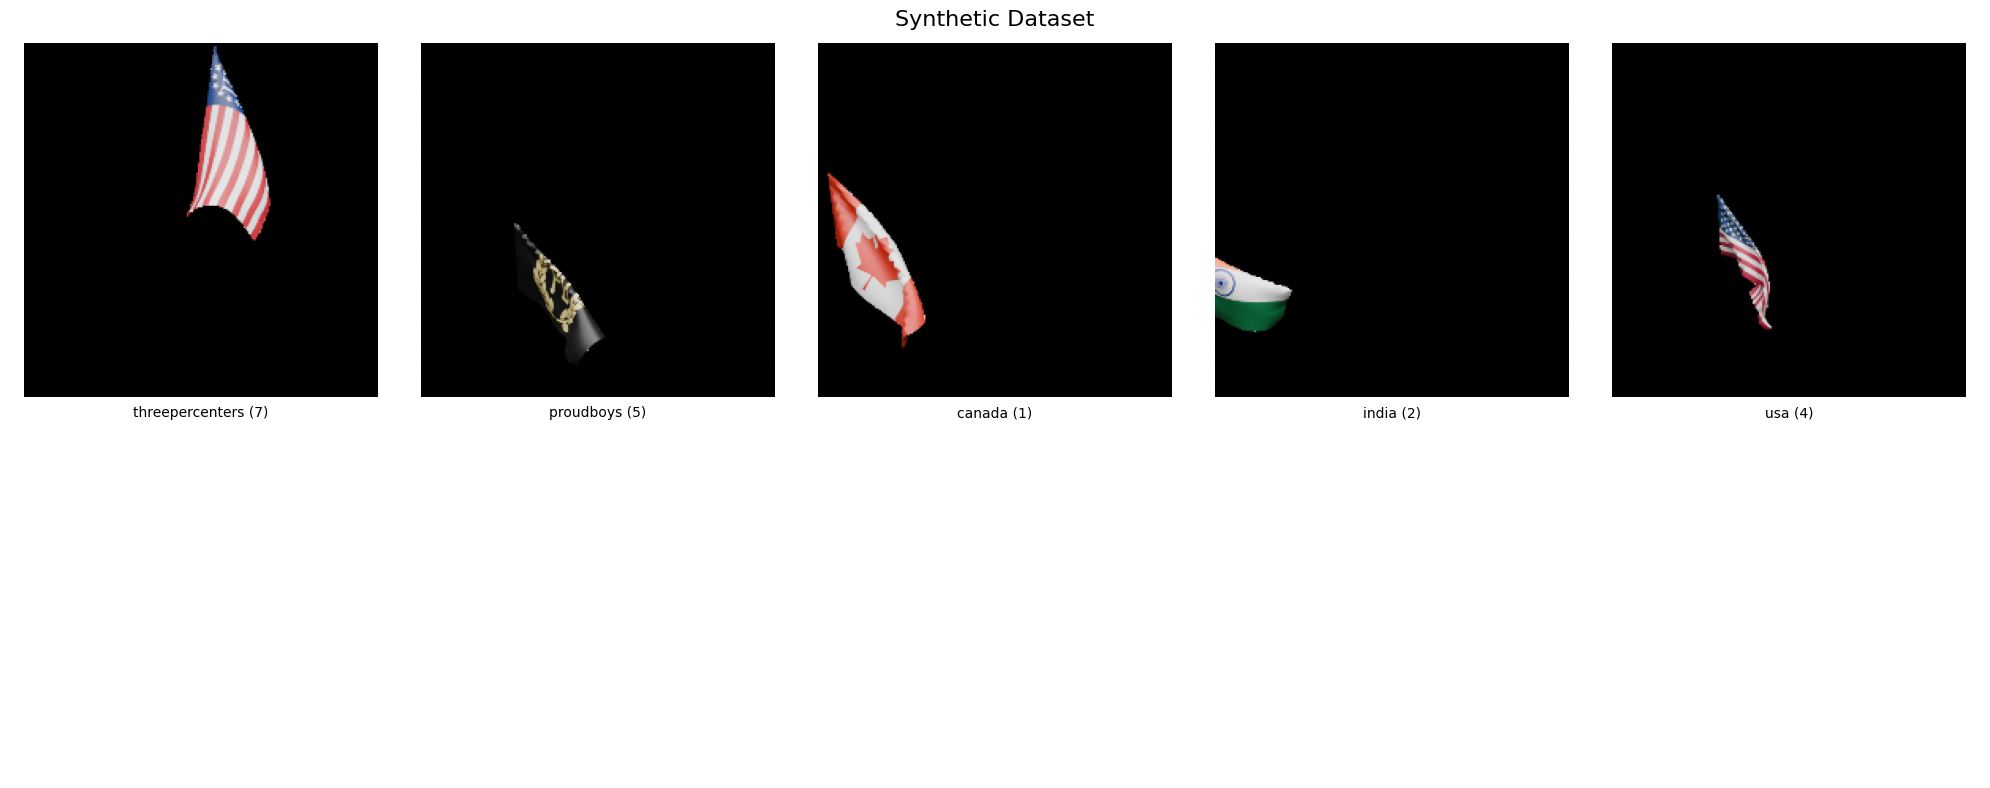

In [ ]:
visualize_images(synthetic_images, synthetic_labels, synthetic_labels_dict, title="Synthetic Dataset")

## Cropping, Scaling, and Padding Synthetic Images

In [ ]:
def crop_with_contour(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 200)
    dilated_edges = cv2.dilate(edges, None, iterations=1)

    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Find the largest contour (assumed to be the flag)
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        margin = 20
        x, y, w, h = max(0, x - margin), max(0, y - margin), w + 2 * margin, h + 2 * margin

        # Cropping
        cropped_flag = image[y:y+h, x:x+w]
    else:
        cropped_flag = image

    return cv2.resize(cropped_flag, (224, 224))

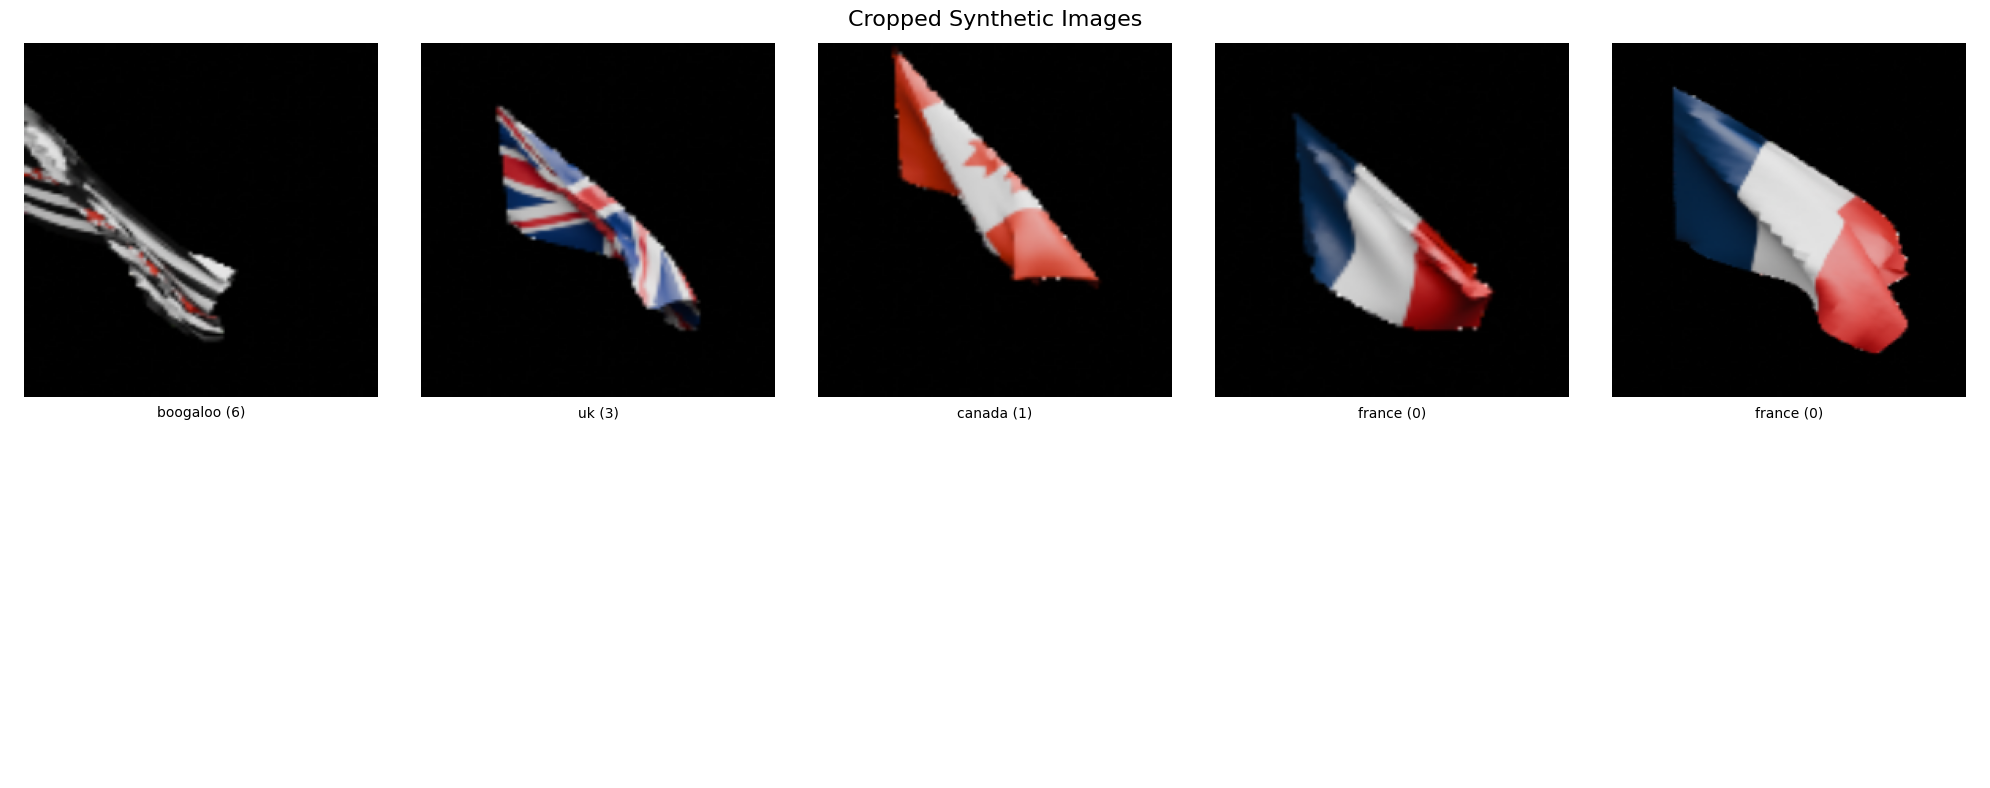

In [ ]:
cropped_synthetic_images = [crop_with_contour(img) for img in synthetic_images]
visualize_images(cropped_synthetic_images, synthetic_labels, synthetic_labels_dict, title= "Cropped Synthetic Images")

In [ ]:
print("Size of cropped flags:", len(cropped_synthetic_images))
print("Size of cropped labels:", len(synthetic_labels))

Size of cropped flags: 1600
Size of cropped labels: 1600


## Data Train-Val-Test Split - Synthetic Flags

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(
    cropped_synthetic_images, synthetic_labels, test_size=0.2, random_state=121, stratify=synthetic_labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=121, stratify=y_temp
)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print("X: ", "Train:", len(X_train), "Validation:", len(X_val), "Test:", len(X_test))
print("y: ", "Train:", len(y_train), "Validation:", len(y_val), "Test:", len(y_test))

X:  Train: 1024 Validation: 256 Test: 320
y:  Train: 1024 Validation: 256 Test: 320


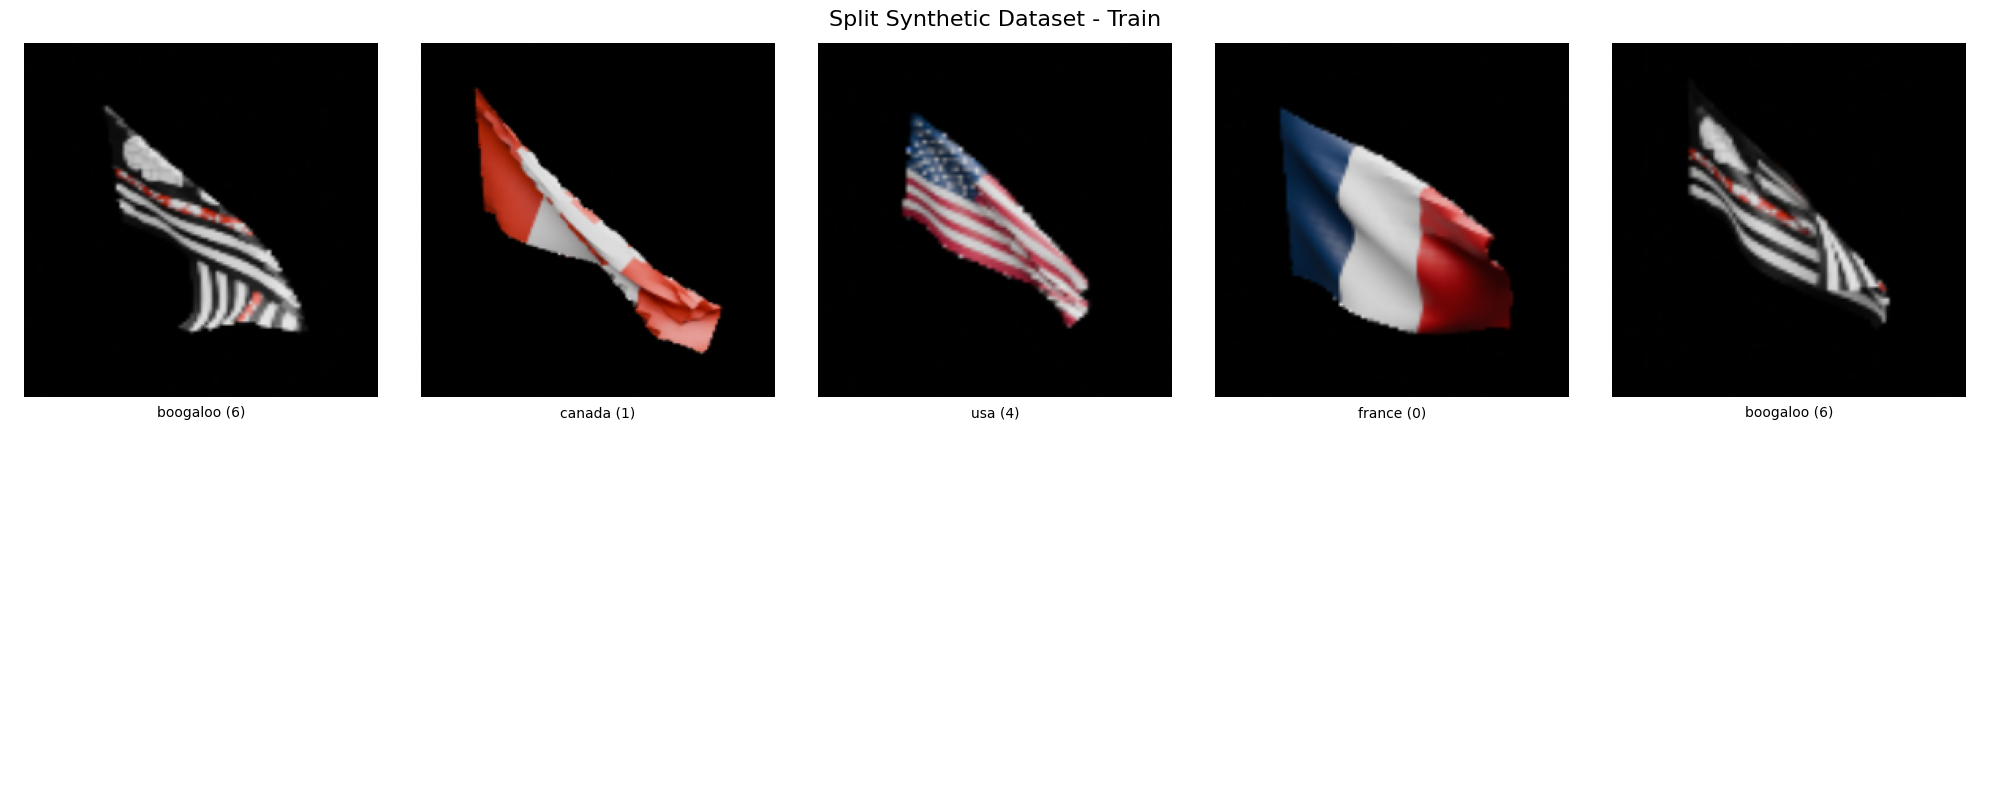

In [ ]:
visualize_images(X_train, y_train, synthetic_labels_dict, title="Split Synthetic Dataset - Train")

## Feature Extraction on Cropped Synthetic Images

### Visualize Feature Extraction

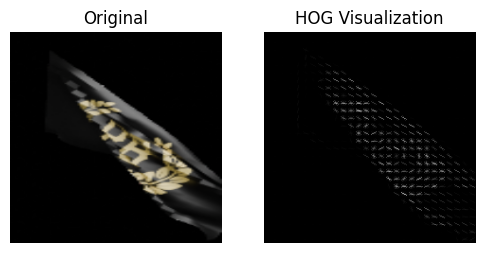

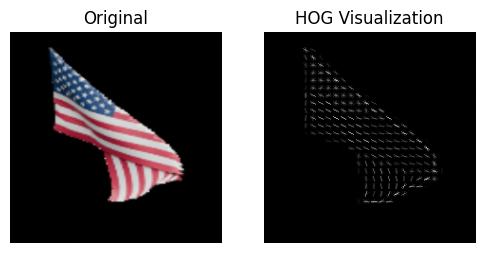

In [ ]:
# Visualize HOG
def visualize_hog(images, num_samples=2):
    indices = random.sample(range(len(images)), num_samples)
    for i in indices:
        img = images[i]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG Visualization')
        plt.axis('off')
        plt.show()

visualize_hog(cropped_synthetic_images)

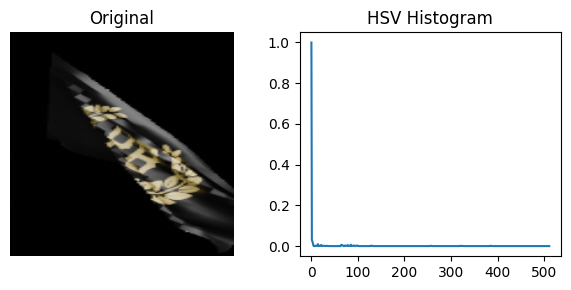

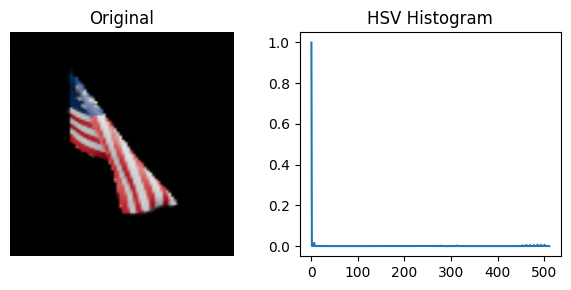

In [ ]:
# Visualize HSV
def visualize_hsv(images, num_samples=2):
    indices = random.sample(range(len(images)), num_samples)
    for i in indices:
        img = images[i]
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1, 2], None, (8, 8, 8), [0, 180, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.plot(hist)
        plt.title('HSV Histogram')
        plt.tight_layout()
        plt.show()

visualize_hsv(cropped_synthetic_images)

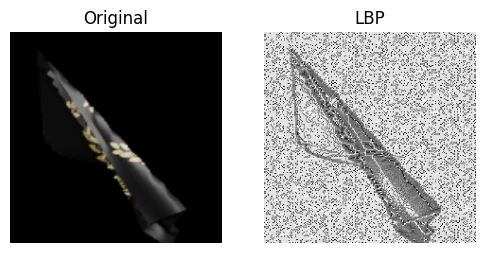

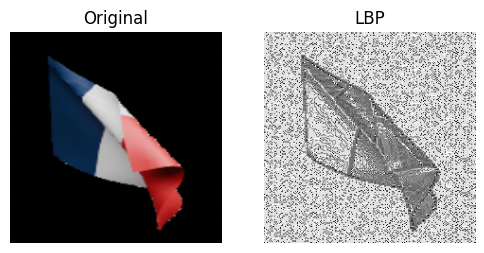

In [ ]:
# Visualize LBP

def visualize_lbp(images, num_samples=2):
    indices = random.sample(range(len(images)), num_samples)
    for i in indices:
        img = images[i]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, 8, 1, method='uniform')

        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(lbp, cmap='gray')
        plt.title('LBP')
        plt.axis('off')
        plt.show()

visualize_lbp(cropped_synthetic_images)

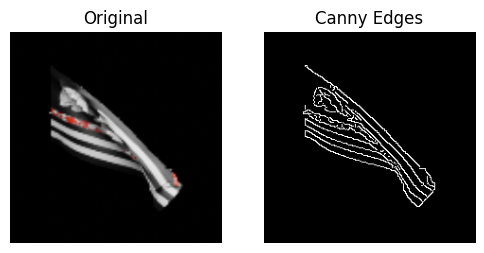

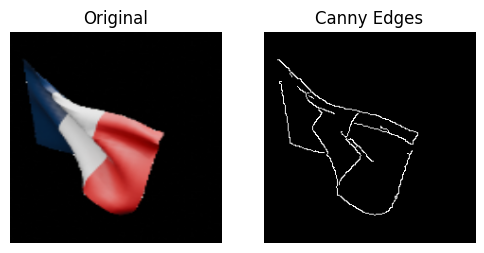

In [ ]:
def visualize_edges(images, num_samples=2, low_thresh=50, high_thresh=200):
    indices = random.sample(range(len(images)), num_samples)
    for i in indices:
        img = images[i]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, low_thresh, high_thresh)

        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edges')
        plt.axis('off')
        plt.show()

visualize_edges(cropped_synthetic_images)

### Feature Extraction Functions

In [ ]:
# Function to extract the features

#HOG
def extract_hog(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
    return features

#HSV
def extract_hsv(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    return cv2.normalize(hist, hist).flatten()

#LBP
def extract_lbp(image, radius=1, points=8):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2))
    return hist.astype("float") / hist.sum()

# Edges
def extract_edges(img, low_thresh=100, high_thresh=200):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, low_thresh, high_thresh)
    return edges.flatten() / 255.0  # Normalize to [0,1]

In [ ]:
# Load ResNet50 model, exclude top layer to use as feature extractor
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_cnn_features(image):
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    features = base_model.predict(image, verbose=0)
    return features.flatten()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#L2 Norms visuals

def plot_l2_norms(feature_list, labels=None, title="L2 Norms of Feature Vectors"):
    norms = np.linalg.norm(feature_list, axis=1)

    plt.figure(figsize=(10, 5))
    if labels is not None:
        for cls in np.unique(labels):
            idx = labels == cls
            plt.hist(norms[idx], bins=40, alpha=0.5, label=f"Class {cls}")
        plt.legend()
    # else:
    #     plt.hist(norms, bins=40, alpha=0.5)

    plt.title(title)
    plt.xlabel("L2 Norm")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

### Synthetic - X_Train

In [ ]:
cnn_features_train = np.array([extract_cnn_features(img) for img in X_train])

In [ ]:
hog_features_train = np.array([extract_hog(img) for img in X_train])

In [ ]:
hsv_features_train = np.array([extract_hsv(img) for img in X_train])

In [ ]:
lbp_features_train = np.array([extract_lbp(img) for img in X_train])

### Synthetic - X_test

In [ ]:
cnn_features_test = np.array([extract_cnn_features(img) for img in X_test])

In [ ]:
hog_features_test = np.array([extract_hog(img) for img in X_test])

In [ ]:
hsv_features_test = np.array([extract_hsv(img) for img in X_test])

In [ ]:
lbp_features_test = np.array([extract_lbp(img) for img in X_test])

### Synthetic - X_val

In [ ]:
cnn_features_val = np.array([extract_cnn_features(img) for img in X_val])

In [ ]:
hog_features_val = np.array([extract_hog(img) for img in X_val])

In [ ]:
hsv_features_val = np.array([extract_hsv(img) for img in X_val])

In [ ]:
lbp_features_val = np.array([extract_lbp(img) for img in X_val])

### L2 Norms Visual for each feature

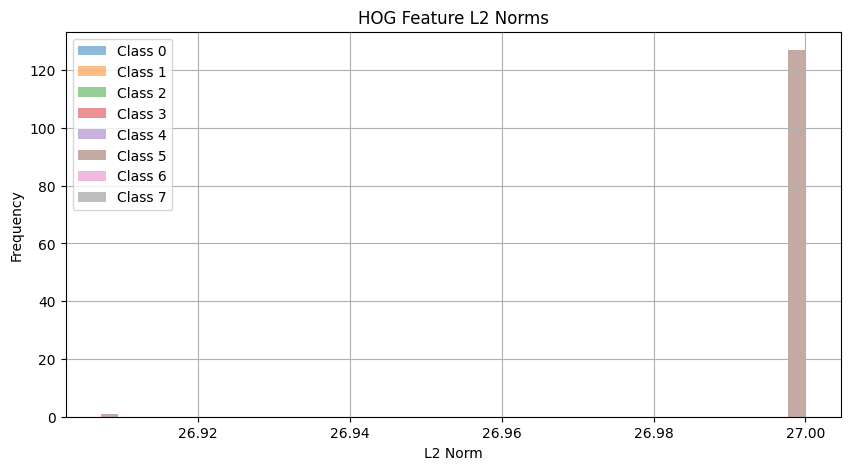

In [ ]:
plot_l2_norms(hog_features_train, y_train, title="HOG Feature L2 Norms")

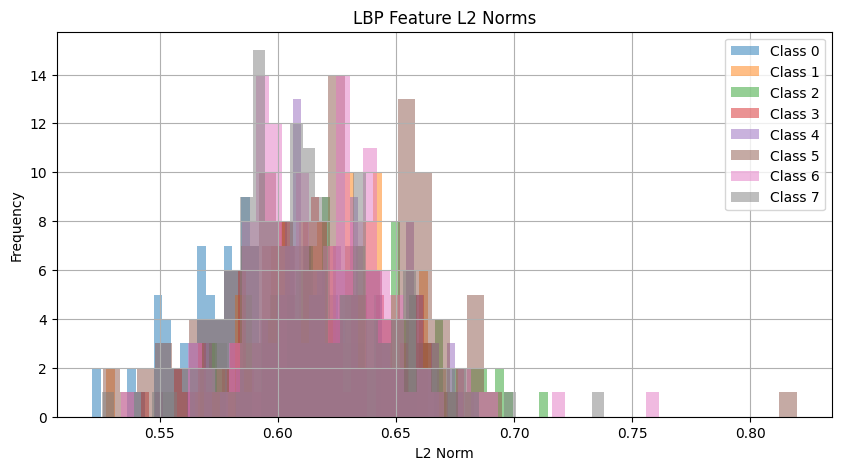

In [ ]:
plot_l2_norms(lbp_features_train, y_train, title="LBP Feature L2 Norms")

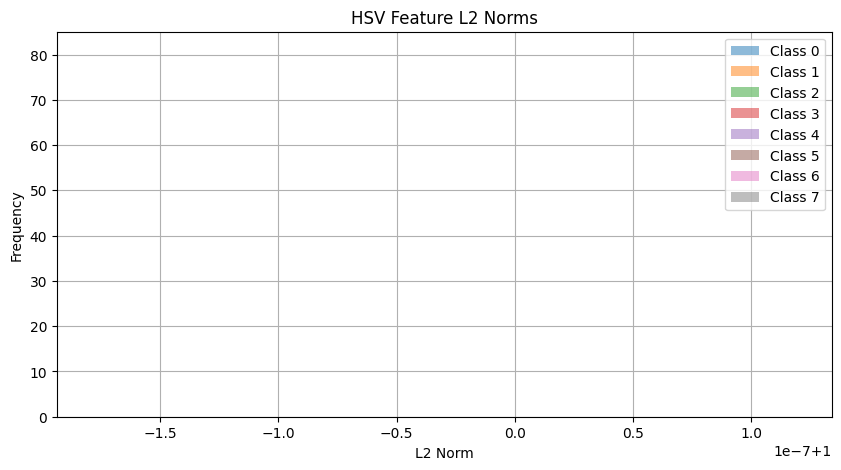

In [ ]:
plot_l2_norms(hsv_features_train, y_train, title="HSV Feature L2 Norms")

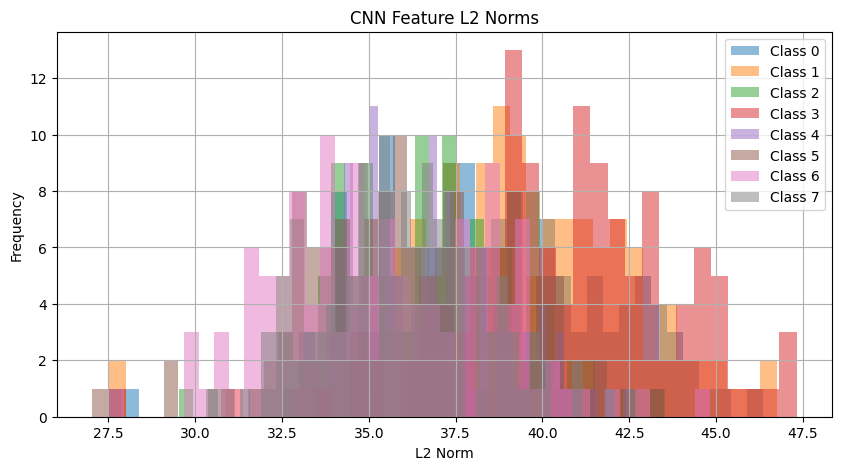

In [ ]:
plot_l2_norms(cnn_features_train, y_train, title="CNN Feature L2 Norms")

## Combining Extracted Features

In [ ]:
def combine_extracted_features(images, cnn_features, hog_features, hsv_features, lbp_features, labels):
    combined_data = []

    for img, cnn_feat, hog_feat, hsv_feat, lbp_feat, label in zip(
            images, cnn_features, hog_features, hsv_features, lbp_features, labels):
        combined_data.append((img, cnn_feat, hog_feat, hsv_feat, lbp_feat, label))

    # Shuffle the combined data to mix everything
    np.random.shuffle(combined_data)

    # Unpack after shuffle
    shuffled_images = [item[0] for item in combined_data]
    shuffled_cnn_features = [item[1] for item in combined_data]
    shuffled_hog_features = [item[2] for item in combined_data]
    shuffled_hsv_features = [item[3] for item in combined_data]
    shuffled_lbp_features = [item[4] for item in combined_data]
    shuffled_labels = [item[5] for item in combined_data]

    # Combine all features into one vector per image
    combined_features = np.hstack([
        shuffled_cnn_features,
        shuffled_hog_features,
        shuffled_hsv_features,
        shuffled_lbp_features,
    ])

    print("Shape of combined features:", combined_features.shape)

    return combined_features, shuffled_labels, shuffled_images


In [ ]:
train_features, train_labels, train_images = combine_extracted_features(
    X_train, cnn_features_train, hog_features_train, hsv_features_train, lbp_features_train, y_train)

Shape of combined features: (1024, 28814)


In [ ]:
synthetic_val_features, synthetic_val_labels, synthetic_val_images = combine_extracted_features(
    X_val, cnn_features_val, hog_features_val, hsv_features_val, lbp_features_val, y_val)

Shape of combined features: (256, 28814)


In [ ]:
synthetic_test_features, synthetic_test_labels, synthetic_test_images = combine_extracted_features(
    X_test, cnn_features_test, hog_features_test, hsv_features_test, lbp_features_test, y_test)

Shape of combined features: (320, 28814)


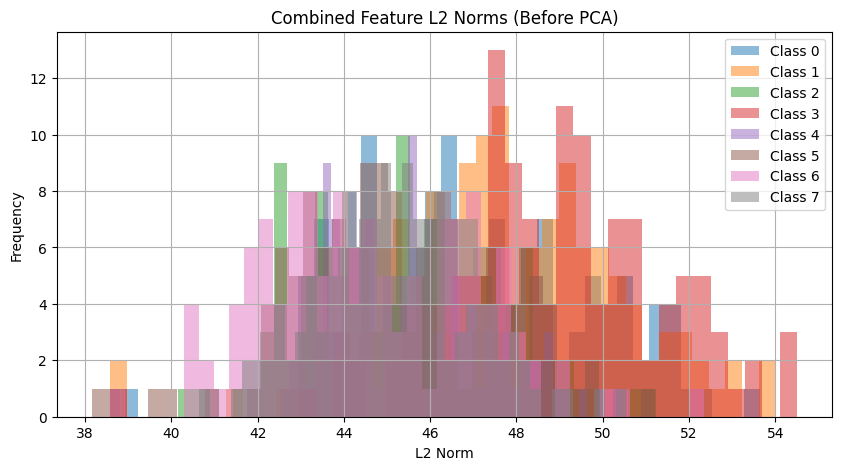

In [ ]:
plot_l2_norms(train_features, np.array(train_labels), title="Combined Feature L2 Norms (Before PCA)")

# PCA Decomposition

In [ ]:
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(train_features)
scaled_val_features = scaler.fit_transform(synthetic_val_features)
scaled_test_features = scaler.fit_transform(synthetic_test_features)

In [ ]:
pca = PCA(n_components=0.95, svd_solver='full')
train_pca = pca.fit_transform(scaled_train_features)
val_pca = pca.transform(scaled_val_features)
test_pca = pca.transform(scaled_test_features)

print(f"This is the train shape after PCA of 95% variance: {train_pca.shape}")
print(f"This is the val shape after PCA of 95% variance: {val_pca.shape}")
print(f"This is the test shape after PCA of 95% variance: {test_pca.shape}")

This is the train shape after PCA of 95% variance: (1024, 758)
This is the val shape after PCA of 95% variance: (256, 758)
This is the test shape after PCA of 95% variance: (320, 758)


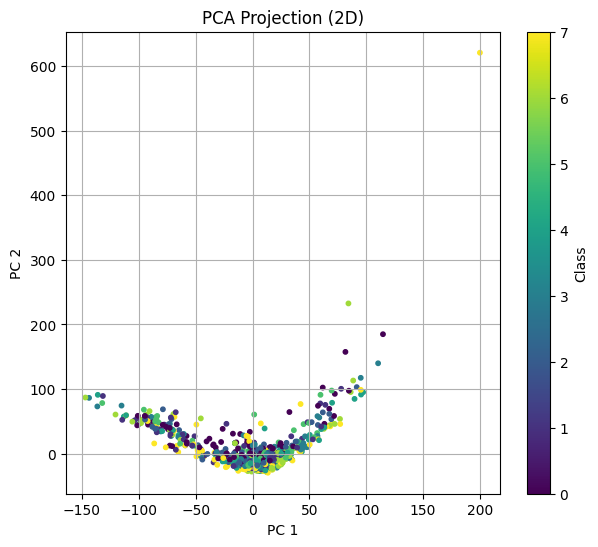

In [ ]:
plt.figure(figsize=(7, 6))
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=train_labels, cmap='viridis', s=10)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Projection (2D)')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()

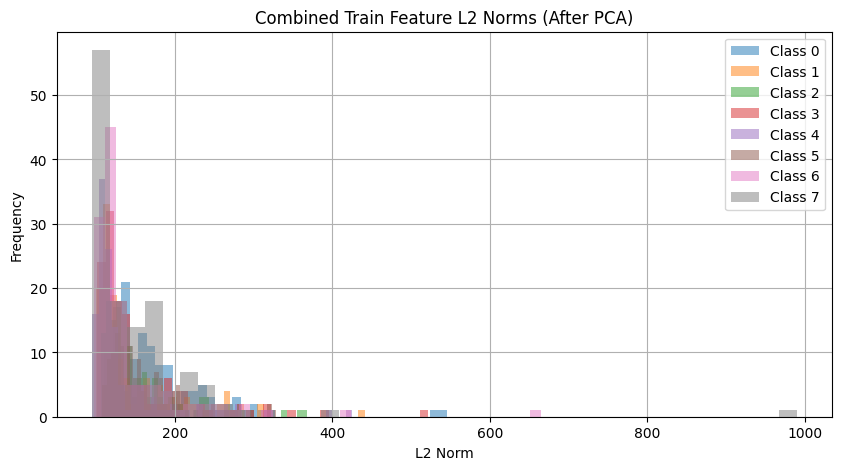

In [ ]:
plot_l2_norms(train_pca, np.array(train_labels), title="Combined Train Feature L2 Norms (After PCA)")

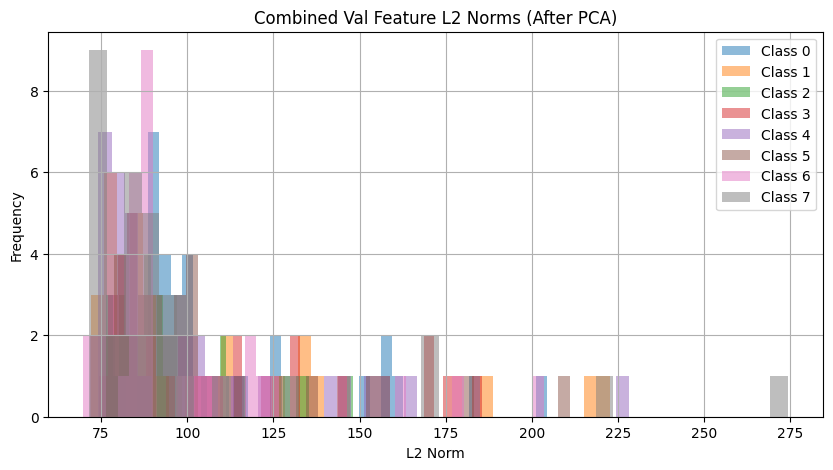

In [ ]:
plot_l2_norms(val_pca, np.array(synthetic_val_labels), title="Combined Val Feature L2 Norms (After PCA)")

# t-SNE (t-distributed Stochastic Neighbor Embedding)

In [ ]:
# TSNE may need hyperparameter tuning depending on perplexity and learning rate
tsne = TSNE(n_components=2, perplexity=15, learning_rate=15, random_state=42)
train_tsne = tsne.fit_transform(scaled_train_features)
val_tsne = tsne.fit_transform(scaled_val_features)
test_tsne = tsne.fit_transform(scaled_test_features)

print(f"This is the train shape after t-SNE: {train_tsne.shape}")
print(f"This is the val shape after t-SNE: {val_tsne.shape}")
print(f"This is the test shape after t-SNE: {test_tsne.shape}")

This is the train shape after t-SNE: (1024, 2)
This is the val shape after t-SNE: (256, 2)
This is the test shape after t-SNE: (320, 2)


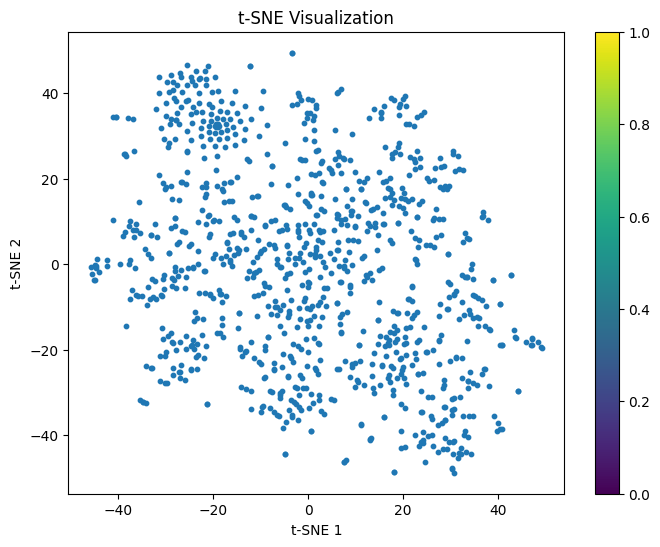

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], s=10)
plt.colorbar()
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

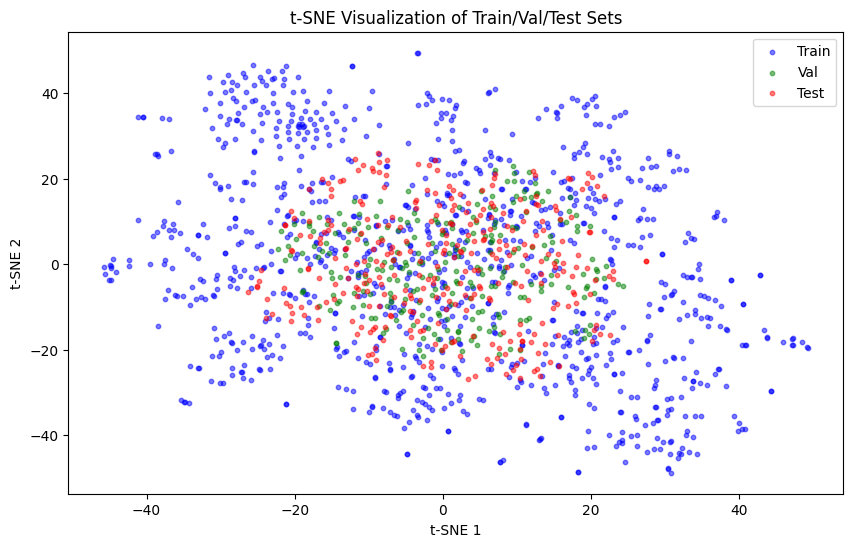

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c='blue', label='Train', alpha=0.5, s=10)
plt.scatter(val_tsne[:, 0], val_tsne[:, 1], c='green', label='Val', alpha=0.5, s=10)
plt.scatter(test_tsne[:, 0], test_tsne[:, 1], c='red', label='Test', alpha=0.5, s=10)
plt.legend()
plt.title("t-SNE Visualization of Train/Val/Test Sets")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


# Model Training

## SVM Model

### Base SVM Model

In [ ]:
#Train an SVM classifier
svm_model = SVC(kernel='linear', random_state=121, C=0.1)

start_time = time.time()

svm_model.fit(train_features, train_labels)
y_pred_svm = svm_model.predict(synthetic_test_features)

end_time = time.time()

accuracy = accuracy_score(synthetic_test_labels, y_pred_svm)
f1 = f1_score(synthetic_test_labels, y_pred_svm, average='weighted')

print(f"SVM Classification Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"SVM Time Taken: {end_time - start_time:.2f} seconds")

SVM Classification Accuracy: 0.99
F1 Score: 0.99
SVM Time Taken: 20.03 seconds


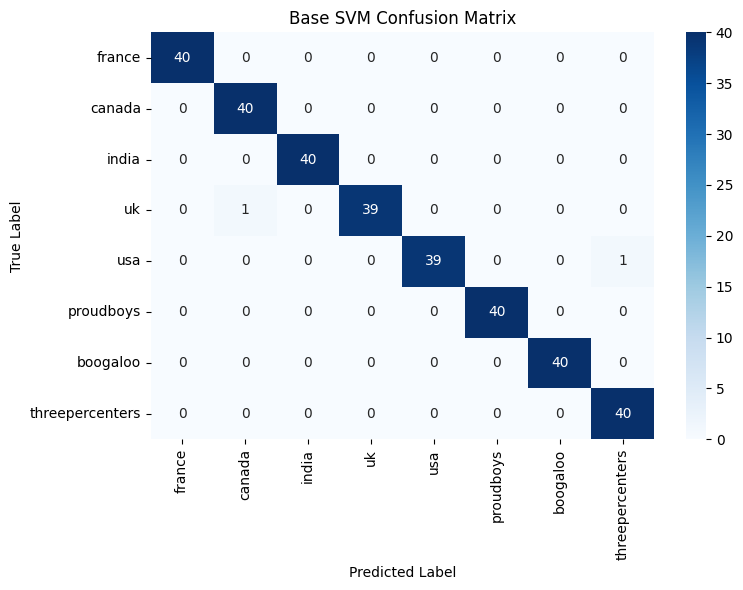

Classification Report: (Base SVM)
                 precision    recall  f1-score   support

         france       1.00      1.00      1.00        40
         canada       0.98      1.00      0.99        40
          india       1.00      1.00      1.00        40
             uk       1.00      0.97      0.99        40
            usa       1.00      0.97      0.99        40
      proudboys       1.00      1.00      1.00        40
       boogaloo       1.00      1.00      1.00        40
threepercenters       0.98      1.00      0.99        40

       accuracy                           0.99       320
      macro avg       0.99      0.99      0.99       320
   weighted avg       0.99      0.99      0.99       320



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(synthetic_test_labels, y_pred_svm)

# Get class labels from the label dict
labels = list(synthetic_labels_dict.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Base SVM Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report: (Base SVM)")
print(classification_report(synthetic_test_labels, y_pred_svm, target_names=labels))


### PCA SVM Model

In [ ]:
#Train an SVM classifier after PCA
svm_model_pca = SVC(kernel='linear', random_state=121, C=0.1)

start_time = time.time()

svm_model_pca.fit(train_pca, train_labels)
y_pred_svm_pca = svm_model_pca.predict(test_pca)

end_time = time.time()

accuracy_pca = accuracy_score(synthetic_test_labels, y_pred_svm_pca)
f1_pca = f1_score(synthetic_test_labels, y_pred_svm_pca, average='weighted')

print(f"SVM Classification Accuracy after PCA: {accuracy_pca:.2f}")
print(f"F1 Score after PCA: {f1_pca:.2f}")
print(f"SVM Time Taken: {end_time - start_time:.2f} seconds")

SVM Classification Accuracy after PCA: 0.97
F1 Score after PCA: 0.98
SVM Time Taken: 0.53 seconds


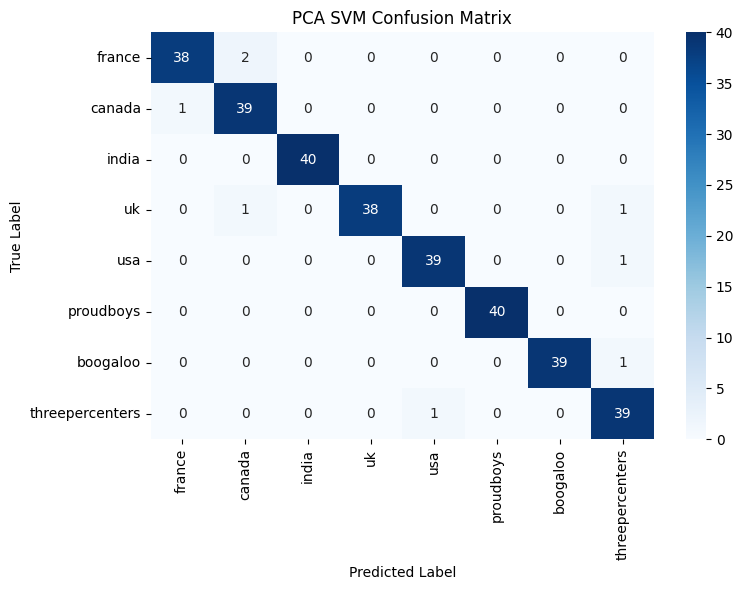

Classification Report: (PCA SVM)
                 precision    recall  f1-score   support

         france       0.97      0.95      0.96        40
         canada       0.93      0.97      0.95        40
          india       1.00      1.00      1.00        40
             uk       1.00      0.95      0.97        40
            usa       0.97      0.97      0.97        40
      proudboys       1.00      1.00      1.00        40
       boogaloo       1.00      0.97      0.99        40
threepercenters       0.93      0.97      0.95        40

       accuracy                           0.97       320
      macro avg       0.98      0.97      0.98       320
   weighted avg       0.98      0.97      0.98       320



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(synthetic_test_labels, y_pred_svm_pca)

# Get class labels from the label dict
labels = list(synthetic_labels_dict.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('PCA SVM Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report: (PCA SVM)")
print(classification_report(synthetic_test_labels, y_pred_svm_pca, target_names=labels))


### Grid Search PCA Data

In [ ]:
#hyperparameter tuning

param_grid_svm = {
    'C': [0.05, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

start_time = time.time()

grid_search_svm = GridSearchCV(SVC(random_state=121),
                               param_grid=param_grid_svm,
                               cv=5,
                               scoring='f1_weighted',
                               n_jobs=-1)

grid_search_svm.fit(train_pca, train_labels)
end_time = time.time()

print(f"Best SVM Params: {grid_search_svm.best_params_}")
print(f"Hyperparameter Tuning Time: {end_time - start_time:.2f} seconds")

best_svm = grid_search_svm.best_estimator_

y_pred_val_best_svm_pca = best_svm.predict(val_pca)
print("Tuned SVM val Accuracy:", round(accuracy_score(synthetic_val_labels, y_pred_val_best_svm_pca), 2))
print("Tuned SVM val F1 Score:", round(f1_score(synthetic_val_labels, y_pred_val_best_svm_pca, average='weighted'), 2))

print("")

y_pred_best_svm_pca = best_svm.predict(test_pca)
print("Tuned SVM test Accuracy:", round(accuracy_score(synthetic_test_labels, y_pred_best_svm_pca), 2))
print("Tuned SVM test F1 Score:", round(f1_score(synthetic_test_labels, y_pred_best_svm_pca, average='weighted'), 2))

Best SVM Params: {'C': 0.05, 'gamma': 'scale', 'kernel': 'linear'}
Hyperparameter Tuning Time: 43.70 seconds
Tuned SVM val Accuracy: 0.97
Tuned SVM val F1 Score: 0.97

Tuned SVM test Accuracy: 0.97
Tuned SVM test F1 Score: 0.98


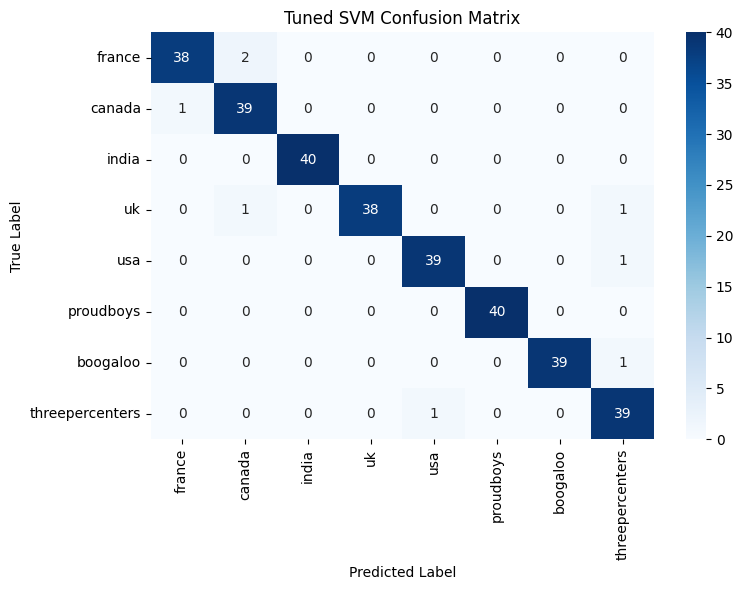

Classification Report: (Tuned SVM)
                 precision    recall  f1-score   support

         france       0.97      0.95      0.96        40
         canada       0.93      0.97      0.95        40
          india       1.00      1.00      1.00        40
             uk       1.00      0.95      0.97        40
            usa       0.97      0.97      0.97        40
      proudboys       1.00      1.00      1.00        40
       boogaloo       1.00      0.97      0.99        40
threepercenters       0.93      0.97      0.95        40

       accuracy                           0.97       320
      macro avg       0.98      0.97      0.98       320
   weighted avg       0.98      0.97      0.98       320



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(synthetic_test_labels, y_pred_best_svm_pca)

# Get class labels from the label dict
labels = list(synthetic_labels_dict.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Tuned SVM Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report: (Tuned SVM)")
print(classification_report(synthetic_test_labels, y_pred_best_svm_pca, target_names=labels))

## Random Forest

### Base RF Model

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=121)

#Start time
start_time = time.time()

rf_model.fit(train_features, train_labels)
y_pred_rf = rf_model.predict(synthetic_test_features)

#End time
end_time = time.time()

accuracy_rf = accuracy_score(synthetic_test_labels, y_pred_rf)
f1_rf = f1_score(synthetic_test_labels, y_pred_rf, average='weighted')

print(f"Random Forest Classification Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest F1 Score: {f1_rf:.2f}")
print(f"Random Forest Time Taken: {end_time - start_time:.2f} seconds")

Random Forest Classification Accuracy: 0.99
Random Forest F1 Score: 0.99
Random Forest Time Taken: 7.23 seconds


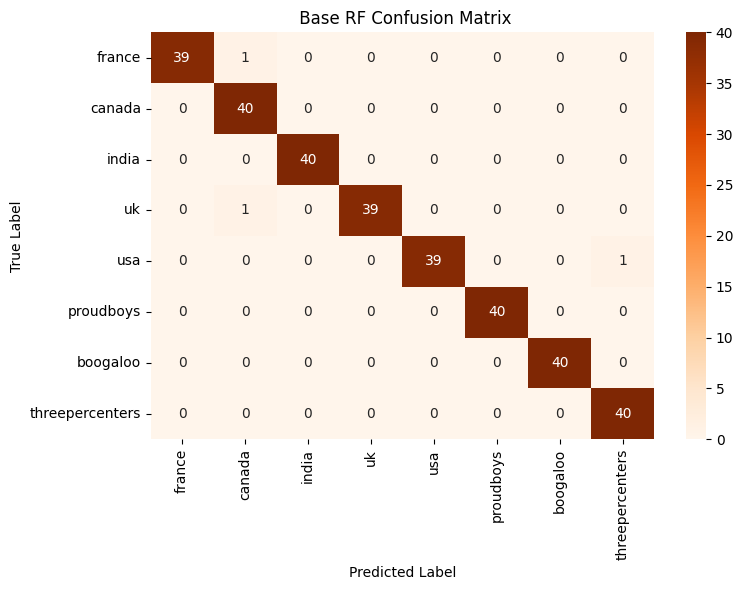

Classification Report (Base Random Forest):
                 precision    recall  f1-score   support

         france       1.00      0.97      0.99        40
         canada       0.95      1.00      0.98        40
          india       1.00      1.00      1.00        40
             uk       1.00      0.97      0.99        40
            usa       1.00      0.97      0.99        40
      proudboys       1.00      1.00      1.00        40
       boogaloo       1.00      1.00      1.00        40
threepercenters       0.98      1.00      0.99        40

       accuracy                           0.99       320
      macro avg       0.99      0.99      0.99       320
   weighted avg       0.99      0.99      0.99       320



In [ ]:
# Compute confusion matrix
cm_rf = confusion_matrix(synthetic_test_labels, y_pred_rf)

# Get class labels (in correct order)
labels = list(synthetic_labels_dict.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(' Base RF Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report (Base Random Forest):")
print(classification_report(synthetic_test_labels, y_pred_rf, target_names=labels))

### PCA RF Model

In [ ]:
# Initialize RF model
rf_model_pca = RandomForestClassifier(n_estimators=100, random_state=121)

# Start time
start_time = time.time()

rf_model_pca.fit(train_pca, train_labels)

y_pred_rf_pca = rf_model_pca.predict(test_pca)

# End time
end_time = time.time()
elapsed_time = end_time - start_time

# Accuracy
accuracy_rf_pca = accuracy_score(synthetic_test_labels, y_pred_rf_pca)
print(f"Random Forest Classification Accuracy after PCA: {accuracy_rf:.2f}")

# F1 Score
f1_rf_pca = f1_score(synthetic_test_labels, y_pred_rf_pca, average='weighted')  # Weighted F1 score
print(f"Random Forest F1 Score after PCA: {f1_rf_pca:.2f}")

print(f"PCA Random Forest Time Taken: {elapsed_time:.2f} seconds")

Random Forest Classification Accuracy after PCA: 0.99
Random Forest F1 Score after PCA: 0.89
PCA Random Forest Time Taken: 2.95 seconds


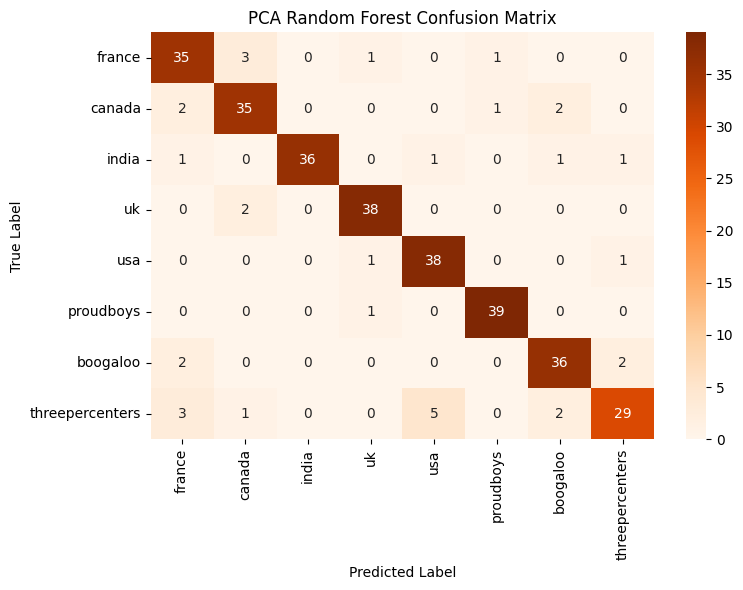

Classification Report (PCA Random Forest):
                 precision    recall  f1-score   support

         france       0.81      0.88      0.84        40
         canada       0.85      0.88      0.86        40
          india       1.00      0.90      0.95        40
             uk       0.93      0.95      0.94        40
            usa       0.86      0.95      0.90        40
      proudboys       0.95      0.97      0.96        40
       boogaloo       0.88      0.90      0.89        40
threepercenters       0.88      0.72      0.79        40

       accuracy                           0.89       320
      macro avg       0.90      0.89      0.89       320
   weighted avg       0.90      0.89      0.89       320



In [ ]:
# Compute confusion matrix
cm_rf = confusion_matrix(synthetic_test_labels, y_pred_rf_pca)

# Get class labels (in correct order)
labels = list(synthetic_labels_dict.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('PCA Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report (PCA Random Forest):")
print(classification_report(synthetic_test_labels, y_pred_rf_pca, target_names=labels))

### Grid Search RF

### RF Grid search on PCA data

In [ ]:
param_grid_rf = {
    'n_estimators': [200, 300],
    'max_depth': [20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

start_time = time.time()

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=121),
                              param_grid=param_grid_rf,
                              cv=5,
                              scoring='f1_weighted',
                              n_jobs=-1)

grid_search_rf.fit(train_pca, train_labels)
end_time = time.time()

print(f"Best Random Forest Params: {grid_search_rf.best_params_}")
print(f"Hyperparameter Tuning Time Taken: {end_time - start_time:.2f} seconds")

best_rf_pca = grid_search_rf.best_estimator_

y_pred_val_best_rf_pca = best_rf_pca.predict(val_pca)
print("Tuned RF validation Accuracy after PCA:", round(accuracy_score(synthetic_val_labels, y_pred_val_best_rf_pca), 2))
print("Tuned RF validation F1 Score after PCA:", round(f1_score(synthetic_val_labels, y_pred_val_best_rf_pca, average='weighted'), 2))

print("")

y_pred_best_rf_pca = best_rf_pca.predict(test_pca)
print("Tuned RF test Accuracy after PCA:", round(accuracy_score(synthetic_test_labels, y_pred_best_rf_pca), 2))
print("Tuned RF test F1 Score after PCA:", round(f1_score(synthetic_test_labels, y_pred_best_rf_pca, average='weighted'), 2))


Best Random Forest Params: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Hyperparameter Tuning Time Taken: 818.02 seconds
Tuned RF validation Accuracy after PCA: 0.91
Tuned RF validation F1 Score after PCA: 0.91

Tuned RF test Accuracy after PCA: 0.92
Tuned RF test F1 Score after PCA: 0.92


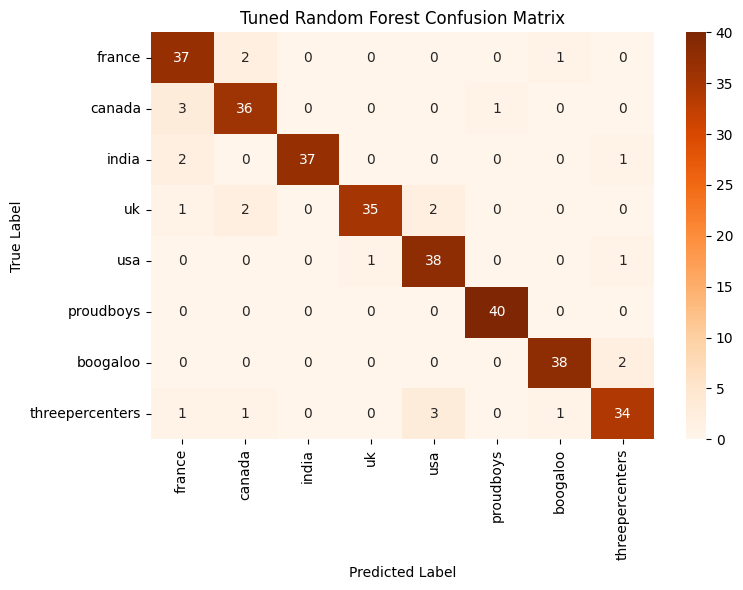

Classification Report (Tuned Random Forest):
                 precision    recall  f1-score   support

         france       0.84      0.93      0.88        40
         canada       0.88      0.90      0.89        40
          india       1.00      0.93      0.96        40
             uk       0.97      0.88      0.92        40
            usa       0.88      0.95      0.92        40
      proudboys       0.98      1.00      0.99        40
       boogaloo       0.95      0.95      0.95        40
threepercenters       0.89      0.85      0.87        40

       accuracy                           0.92       320
      macro avg       0.92      0.92      0.92       320
   weighted avg       0.92      0.92      0.92       320



In [ ]:
# Compute confusion matrix
cm_rf = confusion_matrix(synthetic_test_labels, y_pred_best_rf_pca)

# Get class labels (in correct order)
labels = list(synthetic_labels_dict.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Tuned Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report (Tuned Random Forest):")
print(classification_report(synthetic_test_labels, y_pred_best_rf_pca, target_names=labels))

### Visualize RF Predictions on train data

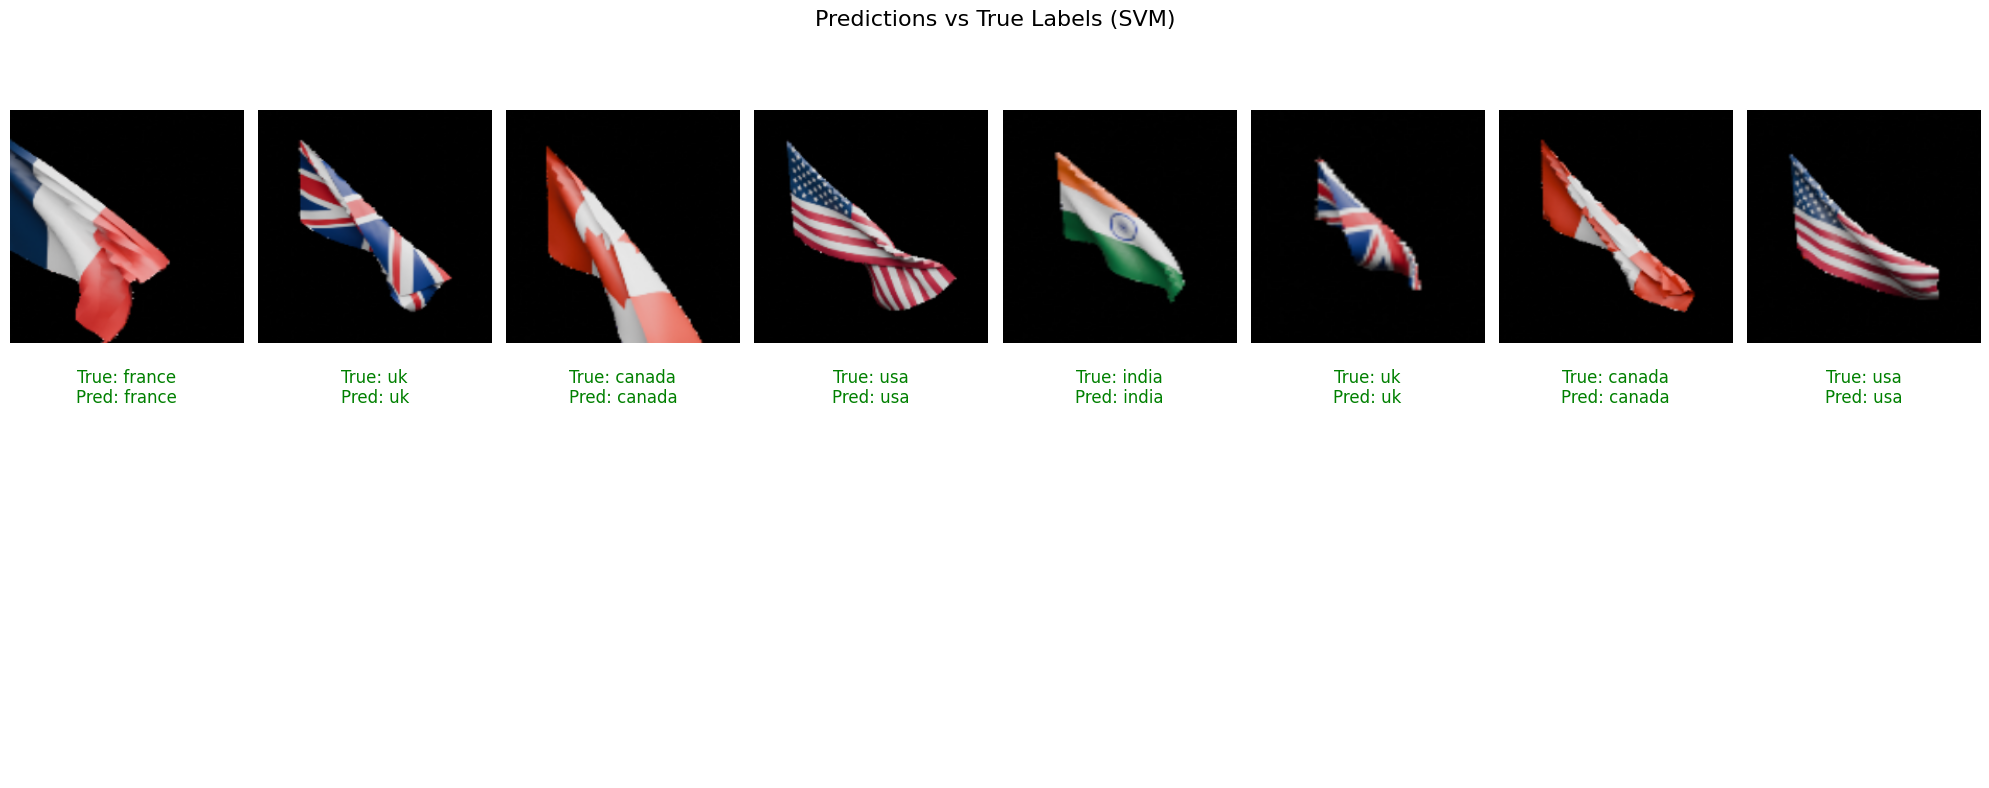

In [ ]:
num_images_to_visualize = 8
random_indices = np.random.choice(len(synthetic_test_features), num_images_to_visualize, replace=False)

# Get the true labels and predicted labels
synthetic_test_labels = np.array(synthetic_test_labels)
y_true = synthetic_test_labels[random_indices]
y_pred = y_pred_svm[random_indices]

# Reverse mapping from numeric labels to category names
label_names = {v: k for k, v in synthetic_labels_dict.items()}

# Create the figure for displaying images
fig, axes = plt.subplots(2, num_images_to_visualize, figsize=(20, 8))
fig.suptitle("Predictions vs True Labels (SVM)", fontsize=16)

# Loop through each selected image and display it
for i, idx in enumerate(random_indices):
    img = synthetic_test_images[idx]

    # Display the original image in the first row
    axes[0, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0, i].axis('off')

    # Get the corresponding label from y_test
    label_index = y_true[i]  # Numeric label
    category_name = label_names[label_index]

    # Display the true and predicted labels in the second row
    color = 'green' if y_true[i] == y_pred[i] else 'red'  # Color for correct/incorrect prediction
    axes[1, i].set_title(f"True: {category_name}\nPred: {label_names[y_pred[i]]}", color=color)
    axes[1, i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

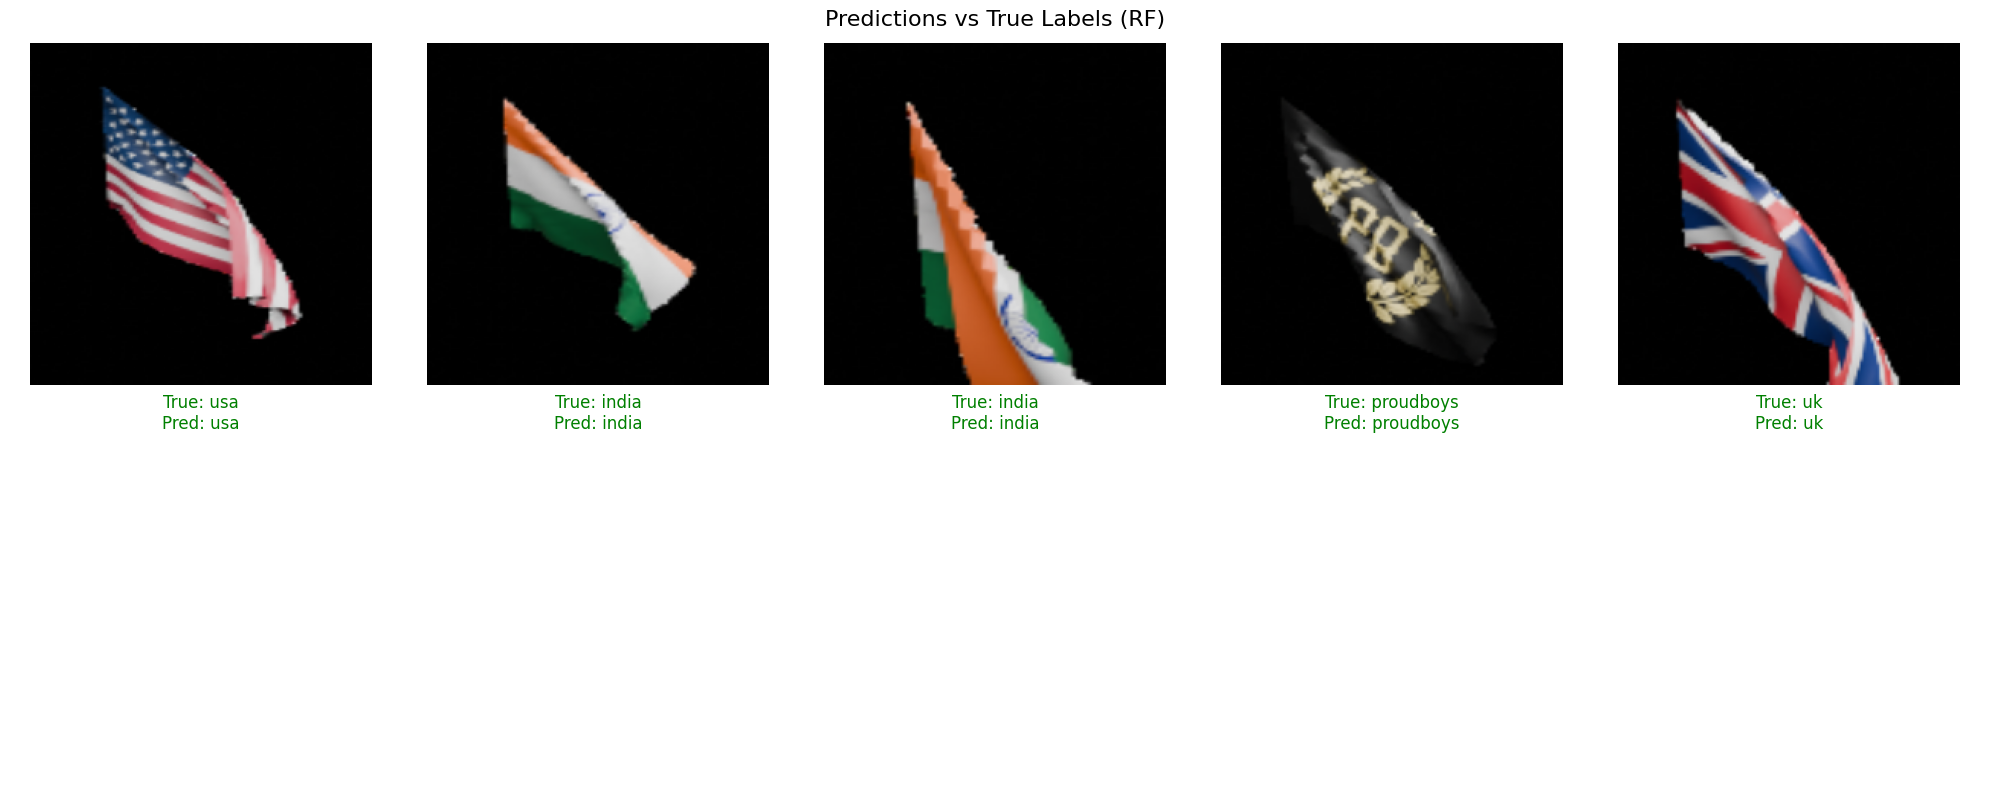

In [ ]:
num_images_to_visualize = 5
random_indices = np.random.choice(len(synthetic_test_features), num_images_to_visualize, replace=False)

# Get the true labels and predicted labels
synthetic_test_labels = np.array(synthetic_test_labels)
y_true = synthetic_test_labels[random_indices]
y_pred = y_pred_rf[random_indices]

# Reverse mapping from numeric labels to category names
label_names = {v: k for k, v in synthetic_labels_dict.items()}

# Create the figure for displaying images
fig, axes = plt.subplots(2, num_images_to_visualize, figsize=(20, 8))
fig.suptitle("Predictions vs True Labels (RF)", fontsize=16)

# Loop through each selected image and display it
for i, idx in enumerate(random_indices):
    img = synthetic_test_images[idx]

    # Display the original image in the first row
    axes[0, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0, i].axis('off')

    # Get the corresponding label from y_test
    label_index = y_true[i]  # Numeric label
    category_name = label_names[label_index]

    # Display the true and predicted labels in the second row
    color = 'green' if y_true[i] == y_pred[i] else 'red'  # Color for correct/incorrect prediction
    axes[1, i].set_title(f"True: {category_name}\nPred: {label_names[y_pred[i]]}", color=color)
    axes[1, i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Test Data - Real-World Images

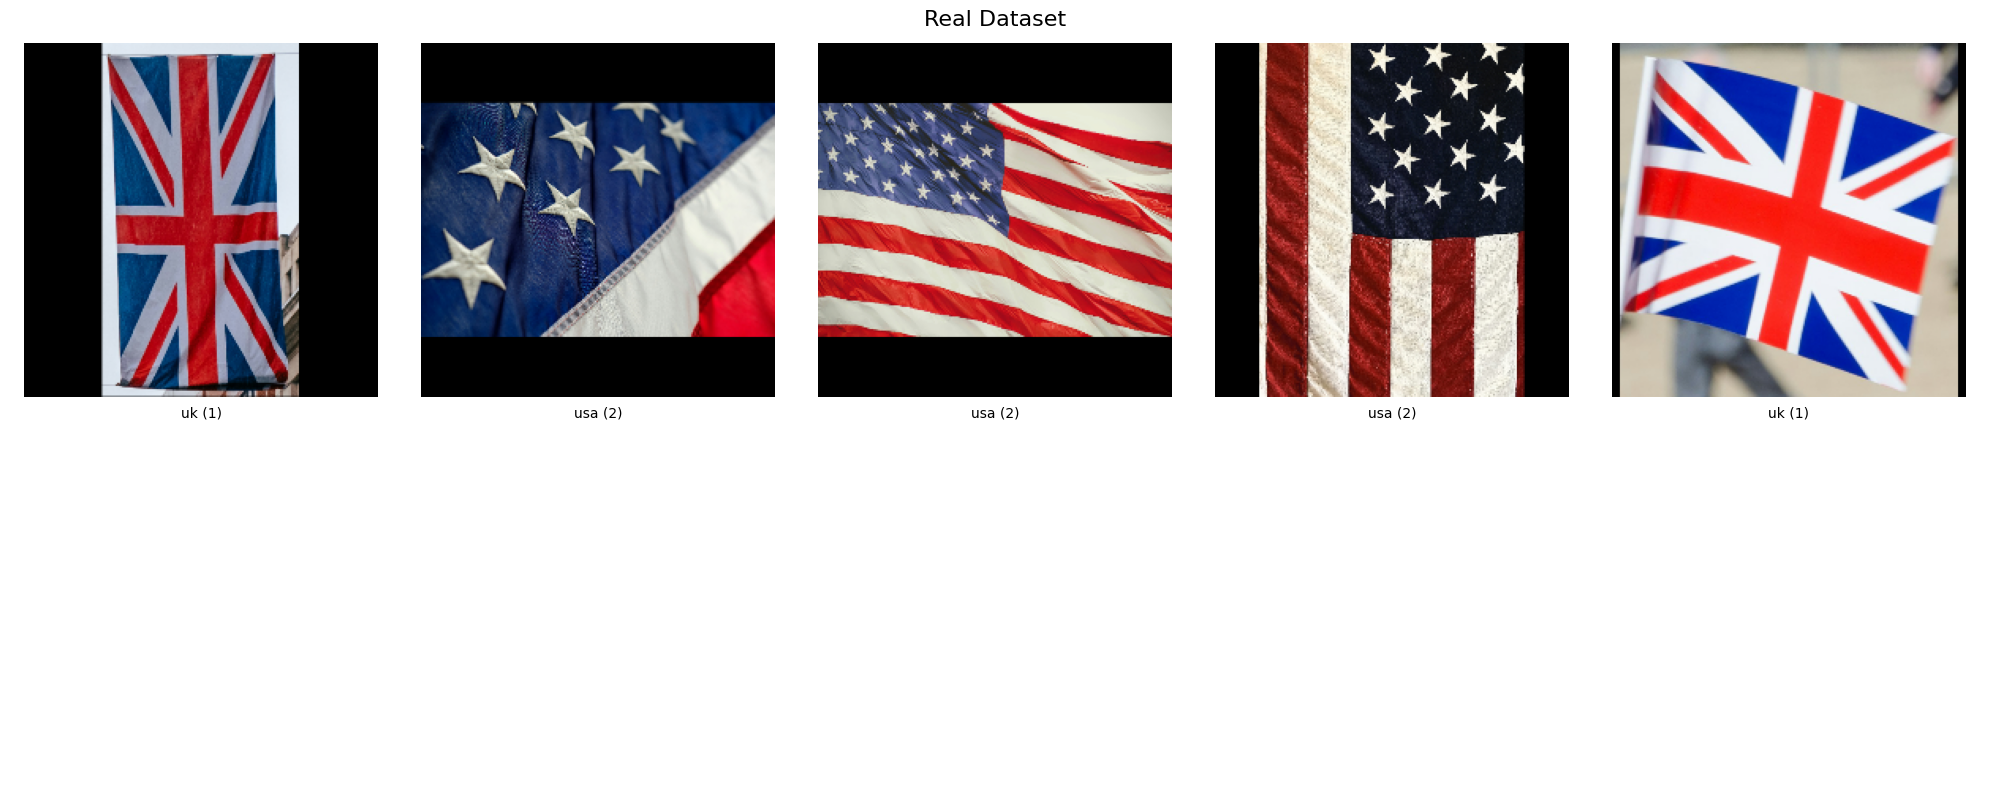

In [ ]:
visualize_images(real_images, real_labels, real_labels_dict, title = "Real Dataset")

In [ ]:
resized_real_test_images = [cv2.resize(img, (224, 224)) for img in real_images]

In [ ]:
# Extract features (HOG, HSV, LBP) for the test data
real_test_cnn_features = np.array([extract_cnn_features(img) for img in resized_real_test_images])
real_test_hog_features = [extract_hog(img) for img in resized_real_test_images]
real_test_hsv_features = [extract_hsv(img) for img in resized_real_test_images]
real_test_lbp_features = [extract_lbp(img) for img in resized_real_test_images]

In [ ]:
## Verify feature extraction
print(f"Shape of CNN features: {np.array(real_test_cnn_features).shape}")
print(f"Shape of HOG features: {np.array(real_test_hog_features).shape}")
print(f"Shape of HSV features: {np.array(real_test_hsv_features).shape}")
print(f"Shape of LBP features: {np.array(real_test_lbp_features).shape}")

Shape of CNN features: (262, 2048)
Shape of HOG features: (262, 26244)
Shape of HSV features: (262, 512)
Shape of LBP features: (262, 10)


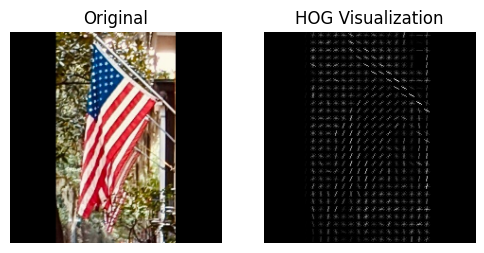

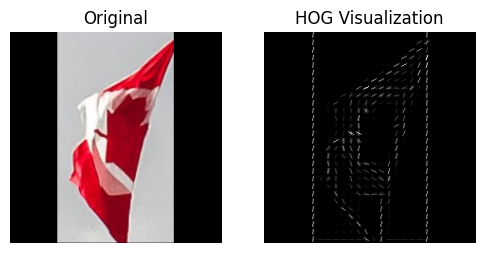

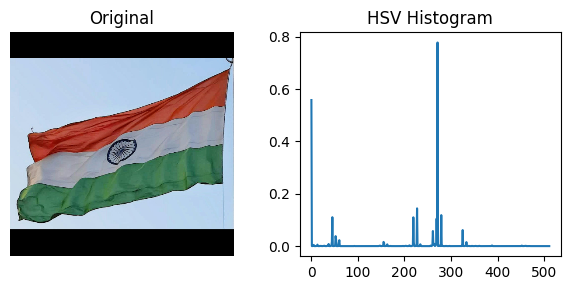

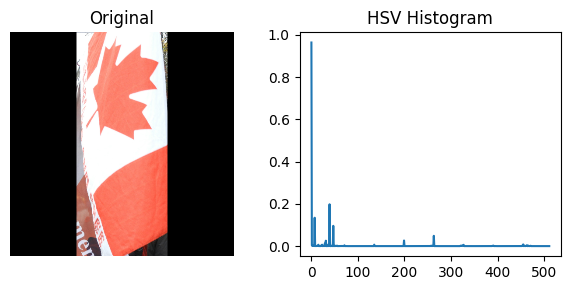

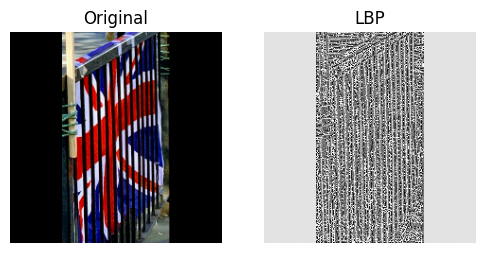

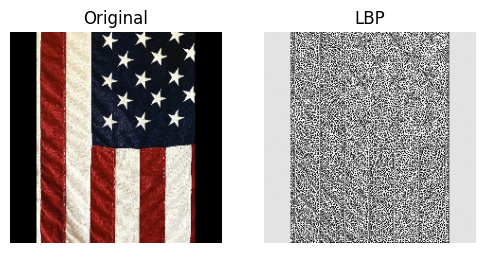

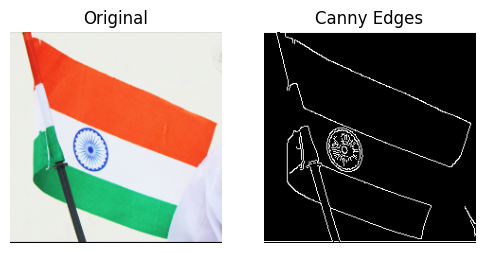

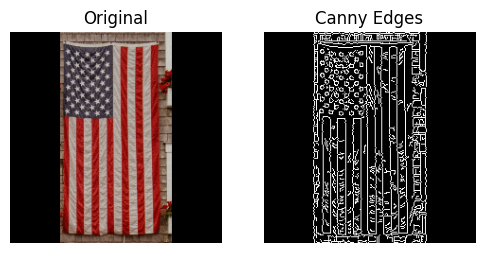

In [ ]:
# Visualize HOG, HSV and LBP on test images

visualize_hog(real_images)
visualize_hsv(real_images)
visualize_lbp(real_images)
visualize_edges(real_images)

In [ ]:
# Combining all features
real_test_combined_features = np.hstack([ real_test_hsv_features,real_test_cnn_features, real_test_hog_features,  real_test_lbp_features])


print(real_test_combined_features.shape)
real_test_features = real_test_combined_features


(262, 28814)


In [ ]:
scaled_real_test_features = scaler.fit_transform(real_test_features)
real_test_pca = pca.transform(scaled_real_test_features)
print(f"This is the shape after PCA of 95% variance: {real_test_pca.shape}")

This is the shape after PCA of 95% variance: (262, 758)


In [ ]:
y_true_real_test = real_labels

In [ ]:
# Predictions of base and PCA Models
#SVM
y_pred_real_test_svm = svm_model.predict(real_test_features)
y_pred_real_test_svm_pca = svm_model_pca.predict(real_test_pca)

# RF
y_pred_real_test_rf_pca = rf_model_pca.predict(real_test_pca)
y_pred_real_test_rf = rf_model.predict(real_test_features)

### SVM

SVM Test Data Accuracy: 0.11
SVM Test Data F1 Score: 0.09


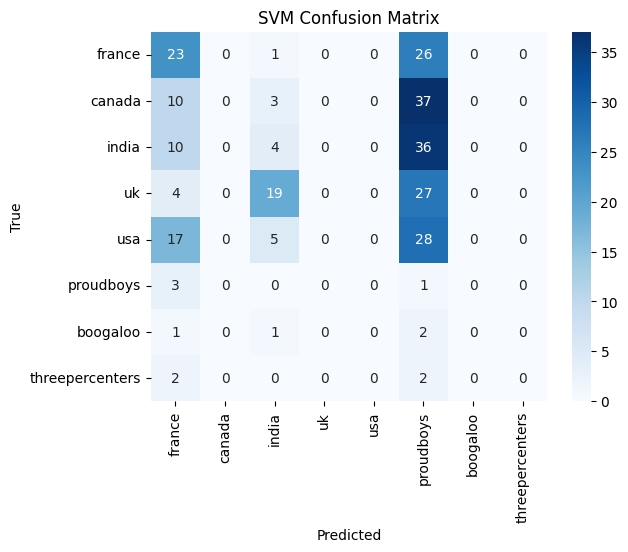

SVM Test Data Accuracy (PCA): 0.17
SVM Test Data F1 Score (PCA): 0.12


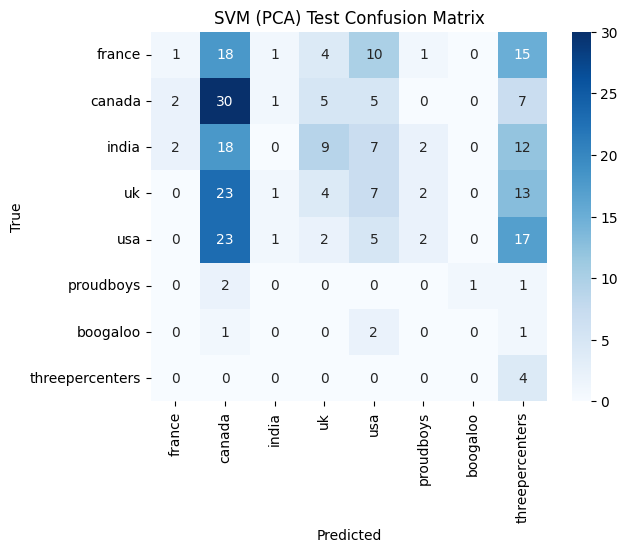

In [ ]:
#SVM model
accuracy_svm = accuracy_score(y_true_real_test, y_pred_real_test_svm)
print(f"SVM Test Data Accuracy: {accuracy_svm:.2f}")

f1_svm = f1_score(y_true_real_test, y_pred_real_test_svm, average='weighted')  # Weighted F1 score
print(f"SVM Test Data F1 Score: {f1_svm:.2f}")

cm_svm = confusion_matrix(y_true_real_test, y_pred_real_test_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#SVM PCA
accuracy_svm_pca = accuracy_score(y_true_real_test, y_pred_real_test_svm_pca)
print(f"SVM Test Data Accuracy (PCA): {accuracy_svm_pca:.2f}")

f1_svm_pca = f1_score(y_true_real_test, y_pred_real_test_svm_pca, average='weighted')  # Weighted F1 score
print(f"SVM Test Data F1 Score (PCA): {f1_svm_pca:.2f}")

cm_svm_pca = confusion_matrix(y_true_real_test, y_pred_real_test_svm_pca)
sns.heatmap(cm_svm_pca, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("SVM (PCA) Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Random Forest

Random Forest Test Data Accuracy: 0.11
Random Forest Test Data F1 Score: 0.08


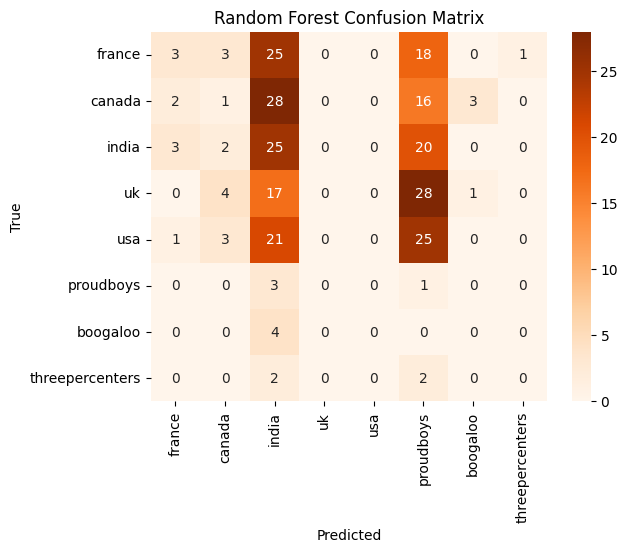

Random Forest Test Data Accuracy (PCA): 0.11
Random Forest Test Data F1 Score(PCA): 0.12


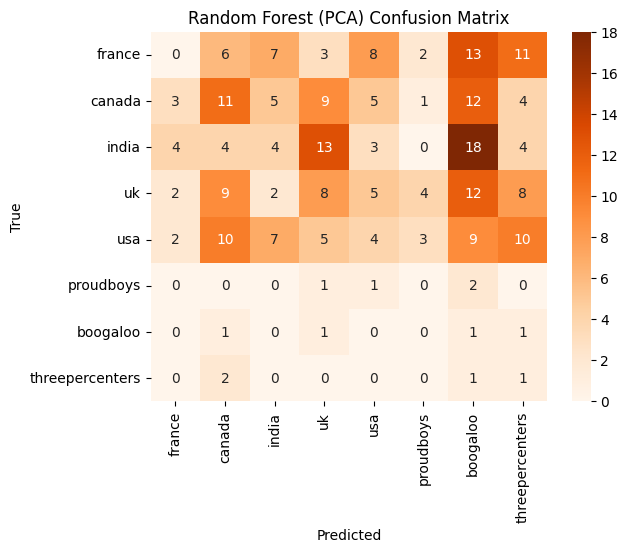

In [ ]:
#Random Forest model
accuracy_rf = accuracy_score(y_true_real_test, y_pred_real_test_rf)
print(f"Random Forest Test Data Accuracy: {accuracy_rf:.2f}")

f1_rf = f1_score(y_true_real_test, y_pred_real_test_rf, average='weighted')  # Weighted F1 score
print(f"Random Forest Test Data F1 Score: {f1_rf:.2f}")

cm_rf = confusion_matrix(y_true_real_test, y_pred_real_test_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#PCA
accuracy_rf_pca = accuracy_score(y_true_real_test, y_pred_real_test_rf_pca)
print(f"Random Forest Test Data Accuracy (PCA): {accuracy_rf_pca:.2f}")

f1_rf_pca = f1_score(y_true_real_test, y_pred_real_test_rf_pca, average='weighted')
print(f"Random Forest Test Data F1 Score(PCA): {f1_rf_pca:.2f}")

cm_rf_pca = confusion_matrix(y_true_real_test, y_pred_real_test_rf_pca)
sns.heatmap(cm_rf_pca, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)
plt.title("Random Forest (PCA) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Grid Search (PCA) data

Tuned SVM Test Data Accuracy: 0.17
Tuned SVM Test Data F1 Score: 0.12


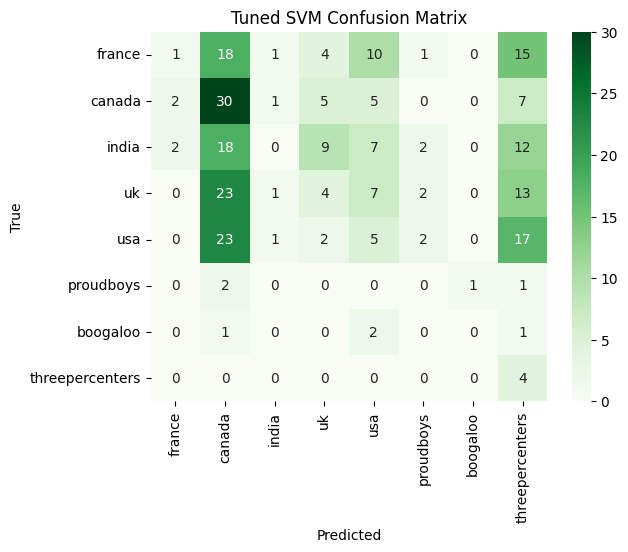

Tuned RF Test Data Accuracy: 0.12
Tuned RF Test Data F1 Score: 0.12


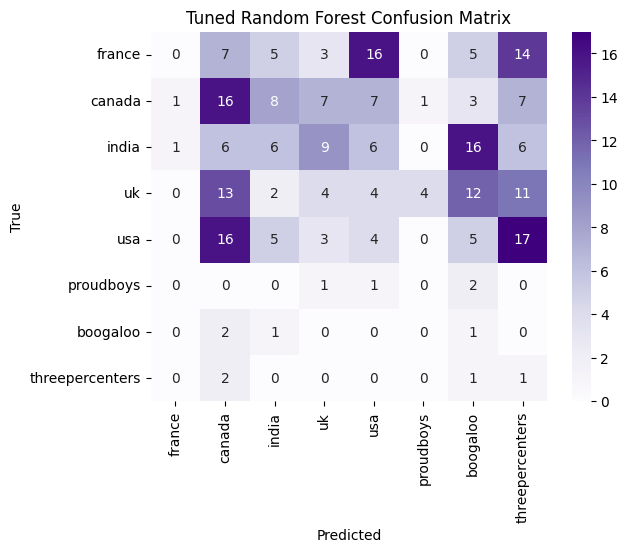

In [ ]:
y_pred_real_test_svm_grid = grid_search_svm.predict(real_test_pca)
y_pred_real_test_rf_grid = grid_search_rf.predict(real_test_pca)

accuracy_svm_grid = accuracy_score(y_true_real_test, y_pred_real_test_svm_grid)
print(f"Tuned SVM Test Data Accuracy: {accuracy_svm_grid:.2f}")

f1_svm_grid = f1_score(y_true_real_test, y_pred_real_test_svm_grid, average='weighted')
print(f"Tuned SVM Test Data F1 Score: {f1_svm_grid:.2f}")

cm_svm_grid = confusion_matrix(y_true_real_test, y_pred_real_test_svm_grid)
sns.heatmap(cm_svm_grid, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title("Tuned SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

accuracy_rf_grid = accuracy_score(y_true_real_test, y_pred_real_test_rf_grid)
print(f"Tuned RF Test Data Accuracy: {accuracy_rf_grid:.2f}")

f1_rf_grid = f1_score(y_true_real_test, y_pred_real_test_rf_grid, average='weighted')
print(f"Tuned RF Test Data F1 Score: {f1_rf_grid:.2f}")

cm_rf_grid = confusion_matrix(y_true_real_test, y_pred_real_test_rf_grid)
sns.heatmap(cm_rf_grid, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title("Tuned Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true_real_test, y_pred_real_test_rf_grid, target_names=labels))

Classification Report:
                 precision    recall  f1-score   support

         france       0.31      0.08      0.13        50
         canada       0.02      0.02      0.02        50
          india       0.04      0.02      0.03        50
             uk       0.14      0.10      0.11        50
            usa       0.22      0.20      0.21        50
      proudboys       0.04      0.25      0.06         4
       boogaloo       0.04      0.25      0.07         4
threepercenters       0.04      0.50      0.08         4

       accuracy                           0.10       262
      macro avg       0.11      0.18      0.09       262
   weighted avg       0.14      0.10      0.10       262



### Visualize Test Predictions

<ipython-input-156-8bc45de195f2>:35: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout(pad=1)


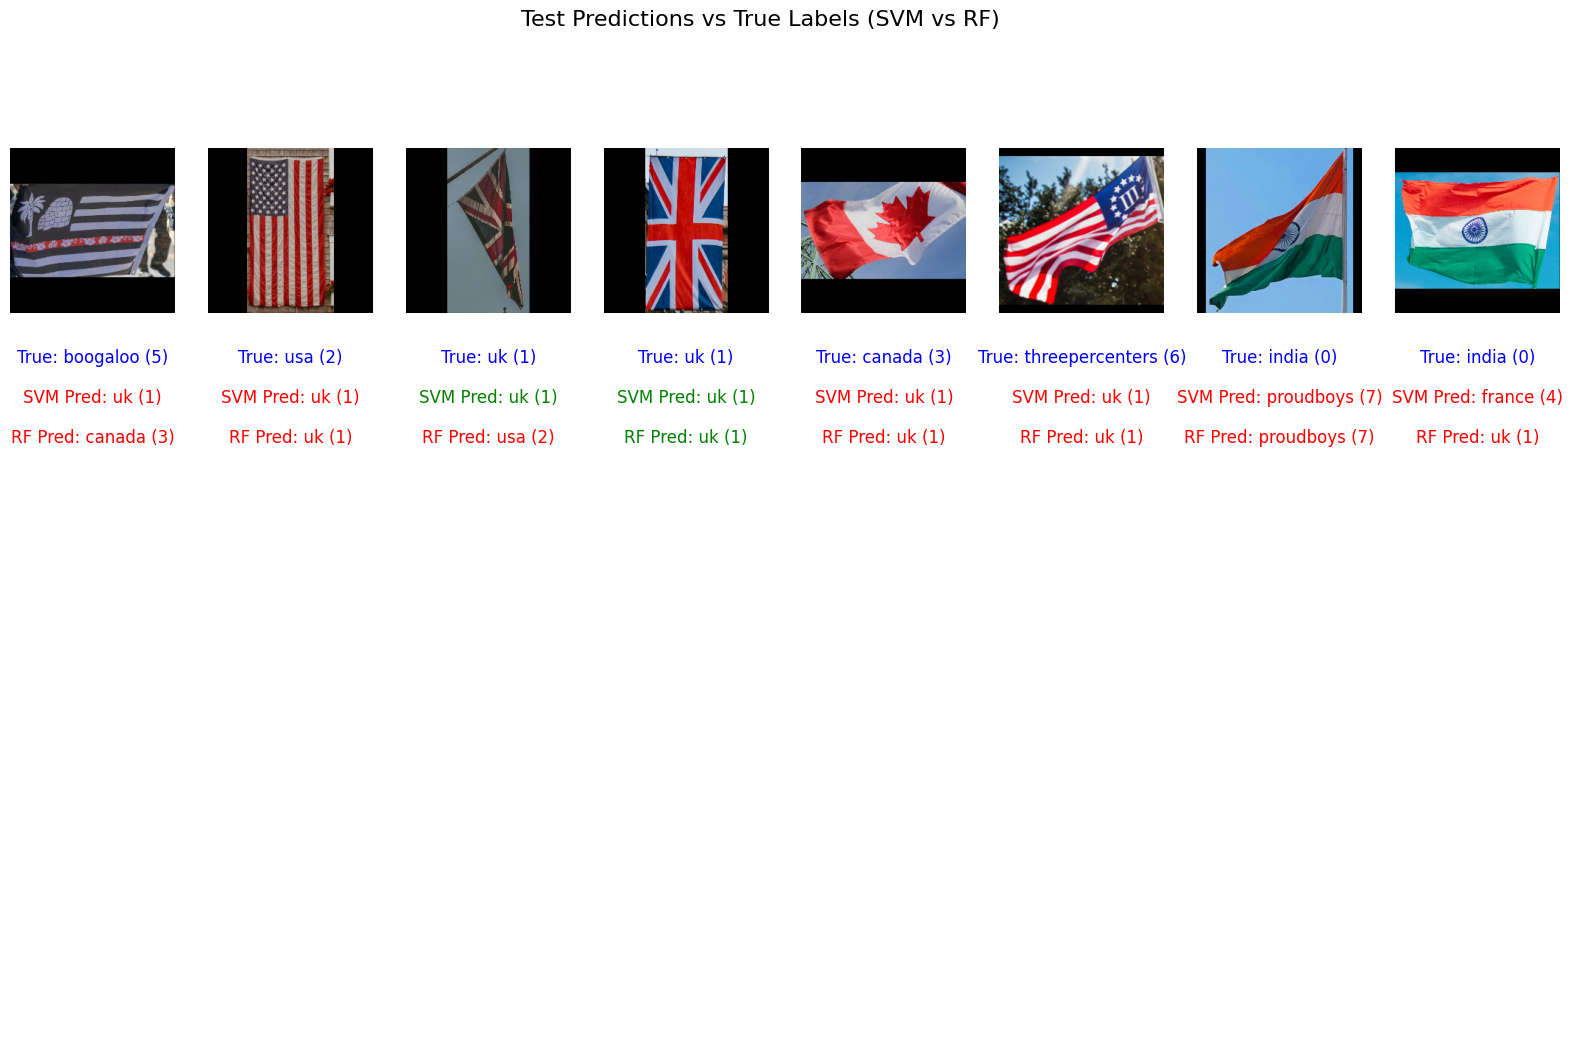

In [ ]:
# Random Images
pred_visualize = 8
random_indices = np.random.choice(len(real_images), pred_visualize, replace=False)

fig, axes = plt.subplots(4, pred_visualize, figsize=(20, 12))
fig.suptitle("Test Predictions vs True Labels (SVM vs RF)", fontsize=16)

for i, idx in enumerate(random_indices):
    img = real_images[idx]  # Get the test image

    # Original Image
    axes[0, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0, i].axis('off')

    # True Label
    label_index_true = y_true_real_test[idx]
    category_name_true = [key for key, val in real_labels_dict.items() if val == label_index_true][0]
    axes[1, i].set_title(f"True: {category_name_true} ({label_index_true})", color='blue')
    axes[1, i].axis('off')

    # SVM Prediction
    label_index_svm = y_pred_real_test_svm_grid[idx]
    category_name_svm = [key for key, val in real_labels_dict.items() if val == label_index_svm][0]
    color_svm = 'green' if label_index_svm == label_index_true else 'red'
    axes[2, i].set_title(f"SVM Pred: {category_name_svm} ({label_index_svm})", color=color_svm, y=2)
    axes[2, i].axis('off')

    # RF Prediction
    label_index_rf = y_pred_real_test_rf_grid[idx]
    category_name_rf = [key for key, val in real_labels_dict.items() if val == label_index_rf][0]
    color_rf = 'green' if label_index_rf == label_index_true else 'red'
    axes[3, i].set_title(f"RF Pred: {category_name_rf} ({label_index_rf})", color=color_rf, y =3)
    axes[3, i].axis('off')

plt.tight_layout(pad=1)
plt.subplots_adjust(hspace=0.2)
plt.show()

# ROC Curves

In [ ]:
# Binarize the output labels
y_train_bin = label_binarize(y_train, classes=list(set(y_train)))
y_test_bin = label_binarize(y_test, classes=list(set(y_test)))
n_classes = y_train_bin.shape[1]

In [ ]:
# Binarize the output labels
synthetic_train_labels_bin = label_binarize(train_labels, classes=list(set(train_labels)))
synthetic_test_labels_bin = label_binarize(synthetic_test_labels, classes=list(set(synthetic_test_labels)))
n_classes = synthetic_train_labels_bin.shape[1]

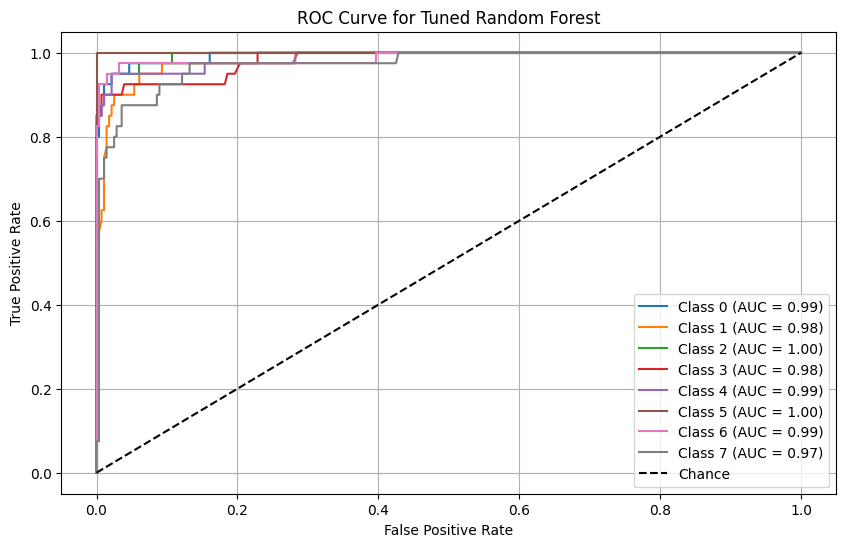

In [ ]:
# ROC curve for Tuned RF
y_score_rf_pca = best_rf_pca.predict_proba(test_pca)

# Compute ROC curves
fpr_rf, tpr_rf, roc_auc_rf = {}, {}, {}
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(synthetic_test_labels_bin[:, i], y_score_rf_pca[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# Plot
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr_rf[i], tpr_rf[i], label=f'Class {i} (AUC = {roc_auc_rf[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title('ROC Curve for Tuned Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# HOG ROC curve
# hog_features_train

In [ ]:
# Use a simple One-vs-Rest SVM on HOG only
svm_hog = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=121))

In [ ]:
np.shape(X_train)

(1024, 224, 224, 3)

In [ ]:
np.shape(y_train_bin)

(1024, 8)

In [ ]:
svm_hog.fit(hog_features_train, y_train_bin)
y_score_hog = svm_hog.decision_function(hog_features_test)

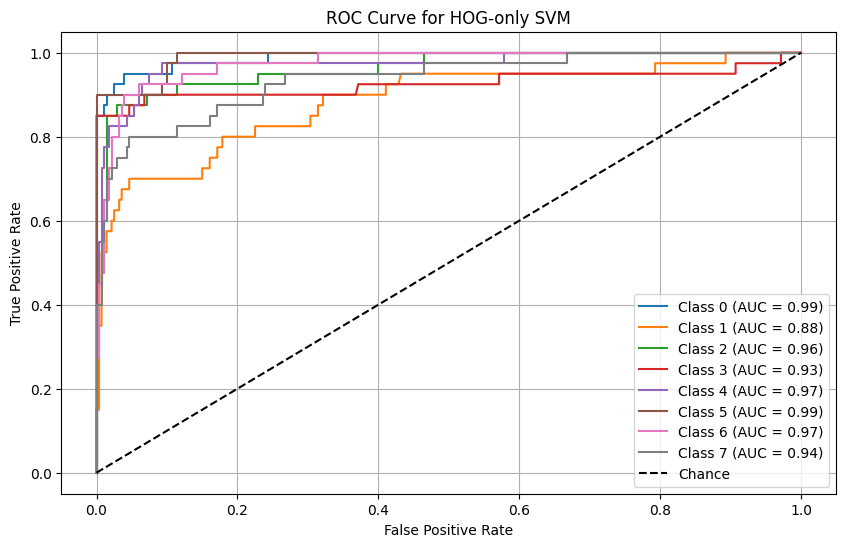

In [ ]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_hog[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for HOG
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title('ROC Curve for HOG-only SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

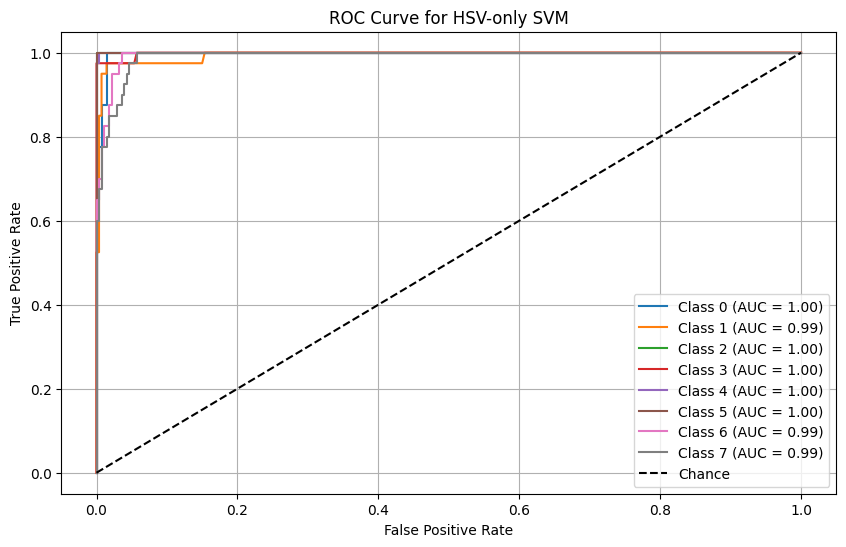

In [ ]:
# HSV ROC curve
# One-vs-Rest SVM classifier
svm_hsv = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=121))
svm_hsv.fit(hsv_features_train, y_train_bin)
y_score_hsv = svm_hsv.decision_function(hsv_features_test)

# Compute ROC curve and AUC for each class
fpr_hsv, tpr_hsv, roc_auc_hsv = {}, {}, {}
for i in range(n_classes):
    fpr_hsv[i], tpr_hsv[i], _ = roc_curve(y_test_bin[:, i], y_score_hsv[:, i])
    roc_auc_hsv[i] = auc(fpr_hsv[i], tpr_hsv[i])

# Plot ROC curves for HSV
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr_hsv[i], tpr_hsv[i], label=f'Class {i} (AUC = {roc_auc_hsv[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title('ROC Curve for HSV-only SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

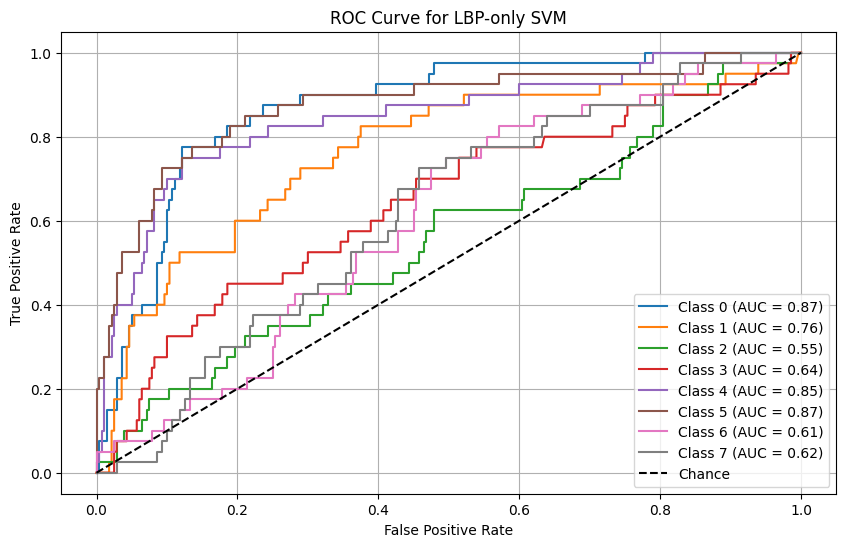

In [ ]:
# LBP ROC curve
# One-vs-Rest SVM classifier
svm_lbp = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=121))
svm_lbp.fit(lbp_features_train, y_train_bin)
y_score_lbp = svm_lbp.decision_function(lbp_features_test)

# Compute ROC curve and AUC for each class
fpr_lbp, tpr_lbp, roc_auc_lbp = {}, {}, {}
for i in range(n_classes):
    fpr_lbp[i], tpr_lbp[i], _ = roc_curve(y_test_bin[:, i], y_score_lbp[:, i])
    roc_auc_lbp[i] = auc(fpr_lbp[i], tpr_lbp[i])

# Plot ROC curves for LBP
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr_lbp[i], tpr_lbp[i], label=f'Class {i} (AUC = {roc_auc_lbp[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title('ROC Curve for LBP-only SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# CNN ROC Curve

In [ ]:
# One-vs-Rest SVM on CNN features
svm_cnn = OneVsRestClassifier(SVC(kernel='linear', C=0.1, probability=True, random_state=121))
svm_cnn.fit(cnn_features_train, y_train_bin)
y_score_cnn = svm_cnn.decision_function(cnn_features_test)

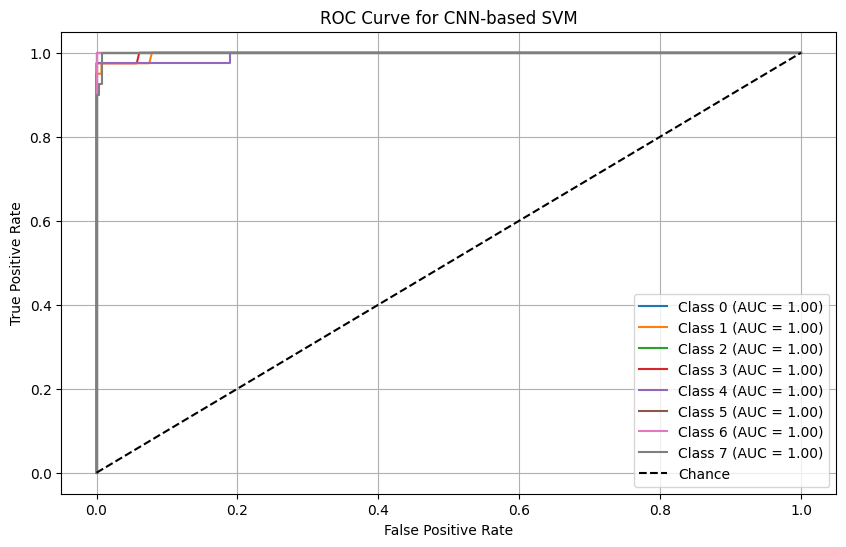

In [ ]:
# Compute ROC curve and AUC for each class
fpr_cnn, tpr_cnn, roc_auc_cnn = {}, {}, {}
for i in range(n_classes):
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_test_bin[:, i], y_score_cnn[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])

# Plot ROC curves for CNN features
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr_cnn[i], tpr_cnn[i], label=f'Class {i} (AUC = {roc_auc_cnn[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title('ROC Curve for CNN-based SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()